# Electricity Price Forecasts in Spain

In [1]:
#Loading required Libraries
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import pandas as pd
import numpy as np
import statsmodels.api as sm
import sklearn
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from dtreeviz.trees import dtreeviz 

In [2]:
#Loading required Datasets
pm_df = pd.read_csv("power_market.csv")
pm_df.head(5)

fc_demand  fc_nuclear  import_FR  export_FR  fc_wind  fc_solar_pv  \
0    24400.0      7117.2     3000.0     2600.0   1732.0          0.0   
1    23616.0      7117.2     3000.0     2650.0   1826.0          0.0   
2    21893.0      7117.2     3000.0     2650.0   1823.0          0.0   
3    20693.0      7117.2     3000.0     2650.0   1777.0          0.0   
4    19599.0      7117.2     3000.0     2650.0   1746.0          0.0   

   fc_solar_th  price        date  hour  
0          5.1  58.82  2017-01-01     0  
1          0.6  58.23  2017-01-01     1  
2          4.6  51.95  2017-01-01     2  
3          9.7  47.27  2017-01-01     3  
4         24.1  45.49  2017-01-01     4

## Exploratory Data Analysis (EDA & Data Preparation)

In [3]:
#Getting a quick preview of the data:
pm_df.describe(include = 'all')

fc_demand    fc_nuclear     import_FR     export_FR       fc_wind  \
count   32135.000000  32135.000000  32122.000000  32122.000000  32135.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean    28475.593527   6421.333431   2445.285163   2217.864703   5627.214688   
std      4686.675600    862.355391    623.215136    550.563300   3266.961919   
min     16372.000000   3672.800000    700.000000    200.000000    139.000000   
25%     24605.500000   6071.900000   2100.000000   1900.000000   3083.000000   
50%     28446.000000   7117.200000   2450.000000   2200.000000   4989.000000   
75%     32124.000000   7117.200000   2900.000000   2600.000000   7610.500000   
max     41103.000000   7117.200000   3700.000000   3700.000000  17232.000000   

         fc_solar_pv   fc_solar_th         price        date          hour  
count   32135.000000  32135.000000  32135.000000       32135  32135.000000  
unique           NaN           NaN           NaN        1339           NaN  
top              NaN           NaN           NaN  2018-10-28           NaN  
freq             NaN           NaN           NaN          25           NaN  
mean     1100.253546    601.186600     48.440119         NaN     11.500296  
std      1512.531532    681.584906     14.842233         NaN      6.922199  
min         0.000000      0.000000      0.030000         NaN      0.000000  
25%         0.000000     31.600000     39.770000         NaN      6.000000  
50%       107.800000    331.400000     49.880000         NaN     12.000000  
75%      2099.350000    957.150000     58.250000         NaN     17.500000  
max      7211.200000   2253.700000    101.990000         NaN     23.000000

In [4]:
#Making use of the pandas profiling library to have a very comprehensive view of our dataset:
#from pandas_profiling import ProfileReport
#report = ProfileReport(pm_df, minimal=False)
#report

#### Comments:

From the Pandas profiling, we can see that we have 10 variables, 9 of them numberic and 1 categorical. The total number of observations is 32135, with 26 values missing. 
- fc_demand: the demand variable varies quite a lot between the minimum and maximum value going from 16372 to 41103. When looking at the distribution of the variable, we can clearly see that the distribution is not normal but the amount of the demand tends to vary. As we know from previous research, demand has an important effect on pricing, so we would expect that whenever the demand changes drastically, we would see a big change in pricing as well.
- fc_nuclear: for nuclear we have values ranging from 3672.8 to 7117.2. When looking at the distribution, we can see that the most frequent value is around the 7000 (has a frequency of 51.6%) and the least around the 5500.
- import_FR: import variable goes from a minimum value of 700 to a maximum of 3700. The distribution is fairly simmetrycal (with a most frequent value of 2400 and skewness of -0.38), and the import seems to vary a lot in quantity. 
- export_FR: the export variable seems to be following more a normal distribution (skewness of -0.144), with lowest values of 200 and highest of 3700. For export as well, the amount is not consistent and we can see the quantity exported changing, probably due to seasonality and whether it is a weekday or weekend.
- fc_wind: the variable has a minimum of 139 and a maximum of 17232. The distribution is skewed to the right (skewness of 0.79) showing less production to be more frequent. This is reflected also in the mean= 5627.21
- fc_solar_pv: the variable has a minimum of 0 and a maximum 7211.2. The zero's here represent a big part of the values (42.2%). This is also suggested but the power law distribution that the data seems to follow. The amount of zeros are probably due to the impossibility of getting solar panel power during the night and the restricted amount of light during winter
- fc_solar_th: the variable follows a similar trend to the fc_solar_pv. The minumum is 0 and the maximum value is 2253.7. The data follows a power law distribution, suggested as well by a skewness of 1.03 and a mean of 601.18. The reason for such a prevalence of zeros is the same as for the solar_pv variable, as the photovoltic cells of the thermal panels cannot react to the sun overnight and in winter. 
- price: price has a minimum of 0.03 and a maximum of 101.99. The distibution is fairly simmetrycal (skewness of -0.35). The average price is around 48 euros with the most frequent value being 50 euros.
- date: the variable is categorical and has one different value for each day and hour. This variable will be important to then split it into new variables that will be used to run our models
- hour: the variable expresses the hour of the day. For each day, we have 24 values for hour. The distribution is uniform as we have the same frequency of each hour in the dataset.

Interactions:
- fc_demand and hour: When looking at the interactions between fc_demand and hour, we can clearly see that during the first hours of the day the demand for energy is very low. This makes sense as most people are sleeping.
- fc_demand and fc_nuclear: We can confirm the high demand for nuclear energy 
- fc_demand and fc_wind: we confirm the low demand for wind energy

Pearson's Correlation:
- fc_demand and hours: the variables seem to be very correlated as the time of the day will impact the consumption and therefore demand of energy (during the night the demand would fall as people are sleeping)
- fc_demand and price: the variables are correlated as the demand of energy has a direct impact on the price that the energy will have
- fc_demand and export_FR: the variables are correlated and according to the demand of energy, the resources left can be allocated to exports
- fc_demand and import_FR: the variables are correlated and according to the demand of energy and the resources available, the amount to be imported is defined
- fc_solar_pv and fc_solar_th: the variables are strongly correlated as they both require the sun. Therefore, when more sun is available, both variables will increase. As one variable changes, the other one will change as well.

Phik Correlation:
The Phik correlation showed similar results to the Pearson's correlation, with some exceptions for solar energy:
- fc_solar_pv and hour: the variables are correlated as more energy is forecasted to be produced during the hours of the day with sun
- fc_solar_th: the variables are correlated as more energy is forecasted to be produced during the hours of the day with sun

## Null Values Treatment

In [5]:
pm_df.isnull().sum()

fc_demand       0
fc_nuclear      0
import_FR      13
export_FR      13
fc_wind         0
fc_solar_pv     0
fc_solar_th     0
price           0
date            0
hour            0
dtype: int64

In [6]:
#Filling with last value shown (Motifs: Small Number of missing values + demand should remain fairly stable from one day to the other)
pm_df.fillna(method='ffill', inplace=True)

In [7]:
pm_df.isnull().sum()

fc_demand      0
fc_nuclear     0
import_FR      0
export_FR      0
fc_wind        0
fc_solar_pv    0
fc_solar_th    0
price          0
date           0
hour           0
dtype: int64

## Outlier Treatment

#### 1. Outlier Removal

In [8]:
pm_df_no_outliers = pm_df.copy()

In [9]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    print("{} outliers removed".format(len(df_in)-len(df_out)))
    return df_out

Analyzing outliers of column: fc_demand
0 outliers removed


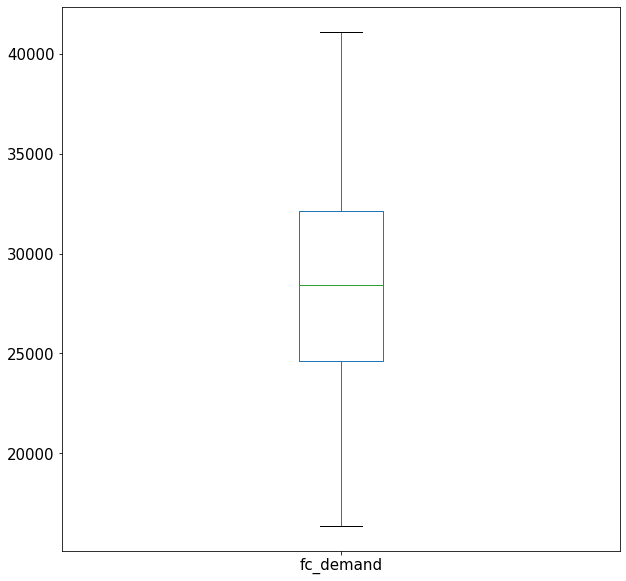

Analyzing outliers of column: fc_nuclear
728 outliers removed


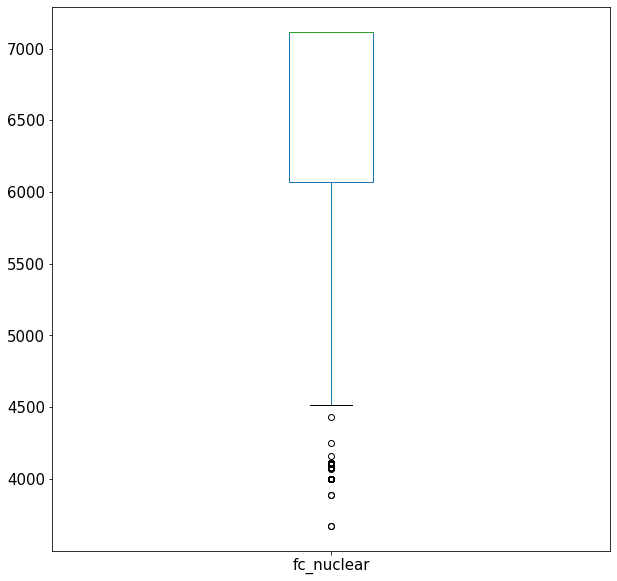

Analyzing outliers of column: import_FR
294 outliers removed


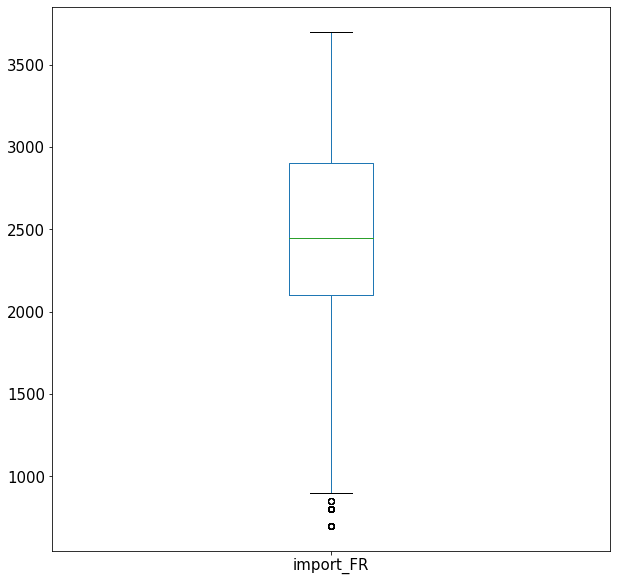

Analyzing outliers of column: export_FR
455 outliers removed


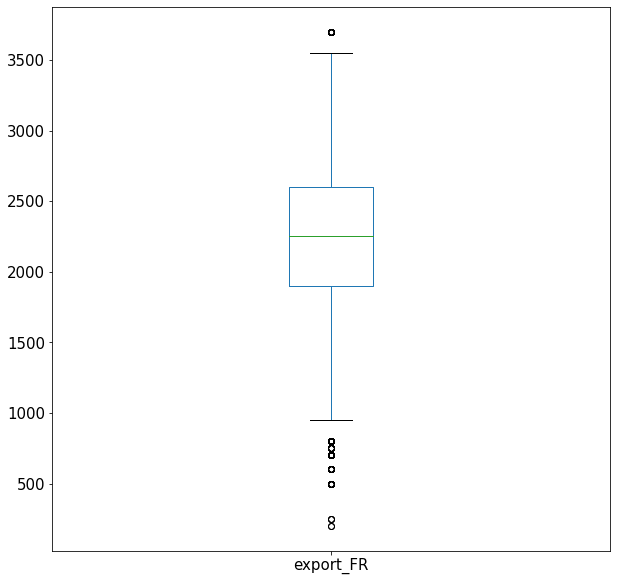

Analyzing outliers of column: fc_wind
342 outliers removed


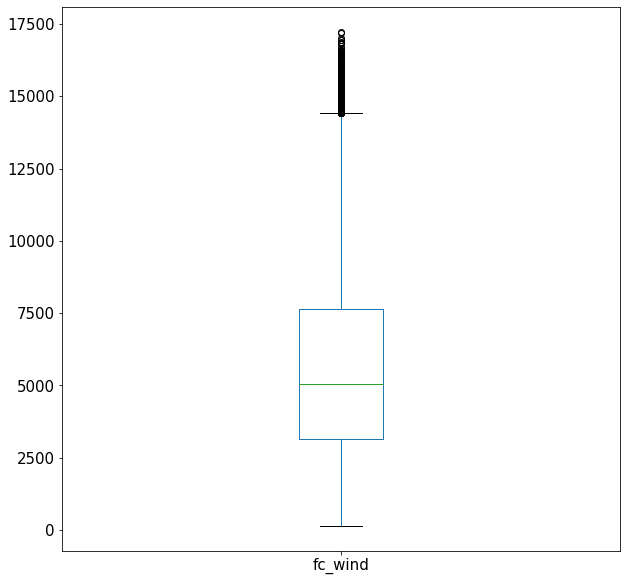

Analyzing outliers of column: fc_solar_pv
763 outliers removed


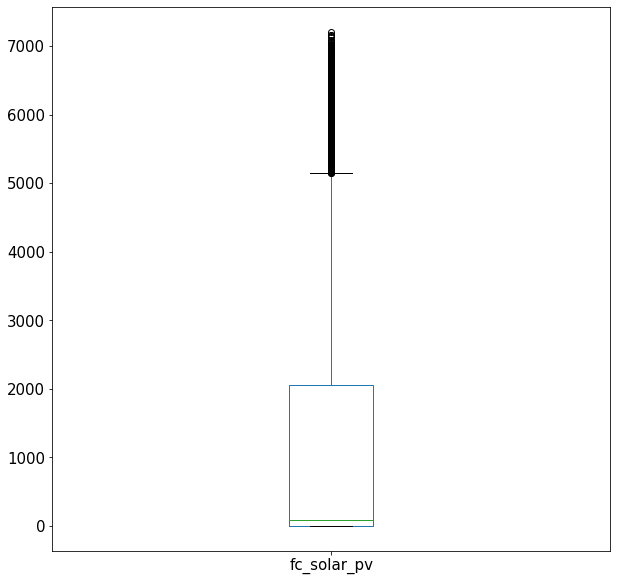

Analyzing outliers of column: fc_solar_th
890 outliers removed


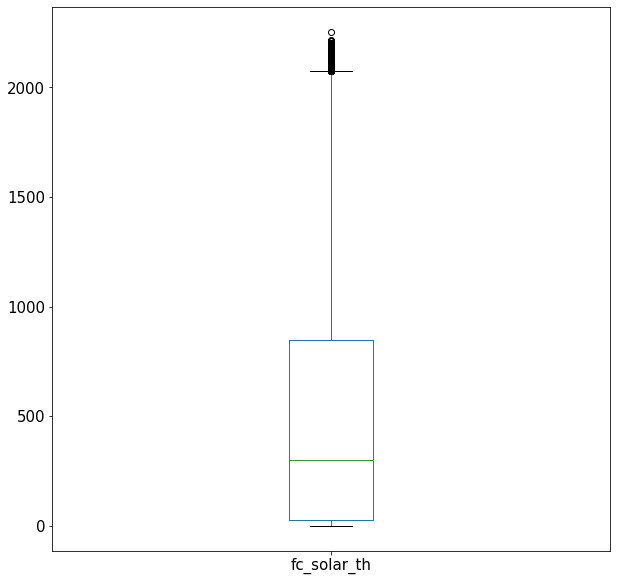

Analyzing outliers of column: price
591 outliers removed


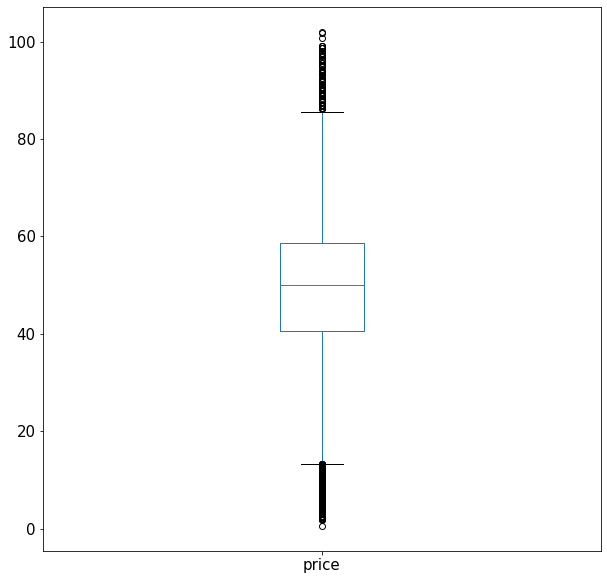

Analyzing outliers of column: hour
0 outliers removed


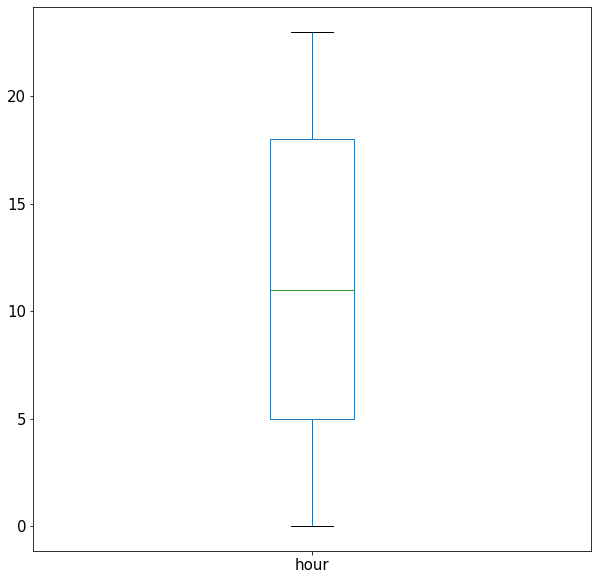

In [10]:
for (columnName, _) in pm_df.iteritems():
    if pm_df_no_outliers[columnName].dtype in ['int64','float64']: 
        print("Analyzing outliers of column: {}".format(columnName))
        plt.figure(figsize=(10,10))
        pm_df_no_outliers.boxplot([columnName], grid=False, fontsize=15)
        pm_df_no_outliers = remove_outlier(pm_df_no_outliers,columnName)
        plt.show()

In [11]:
len(pm_df_no_outliers)

28072

#### 2. Outlier Clipping

In [12]:
pm_df_clipped = pm_df.copy()
def clip_outliers(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    print(str(len(df_in[(df_in[col_name] < fence_low)])+len(df_in[(df_in[col_name] > fence_high)]))+" outliers clipped")
    df_in.at[(df_in[col_name] < fence_low),col_name]=fence_low
    df_in.at[(df_in[col_name] > fence_high),col_name]=fence_high
    return df_in

Analyzing outliers of column: fc_demand
0 outliers clipped


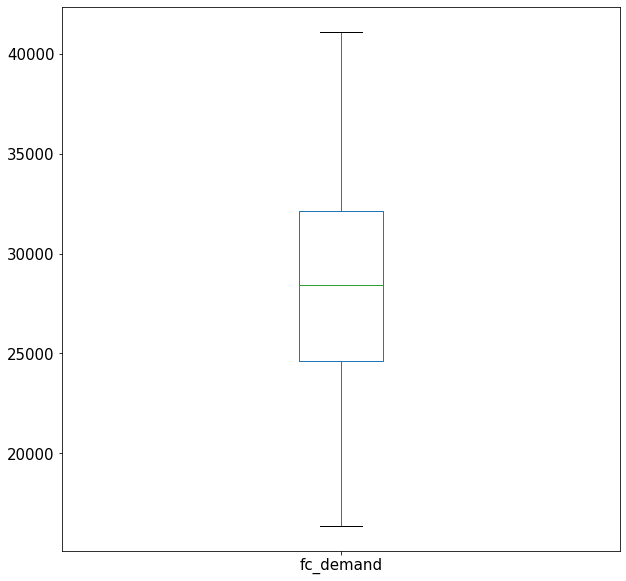

Analyzing outliers of column: fc_nuclear
728 outliers clipped


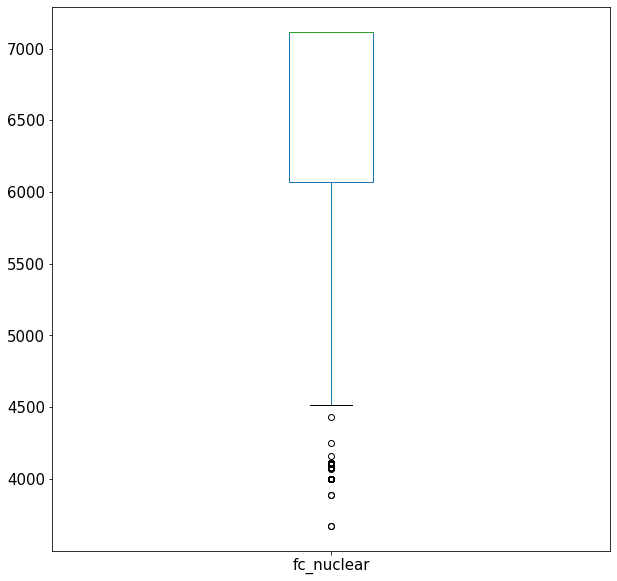

Analyzing outliers of column: import_FR
262 outliers clipped


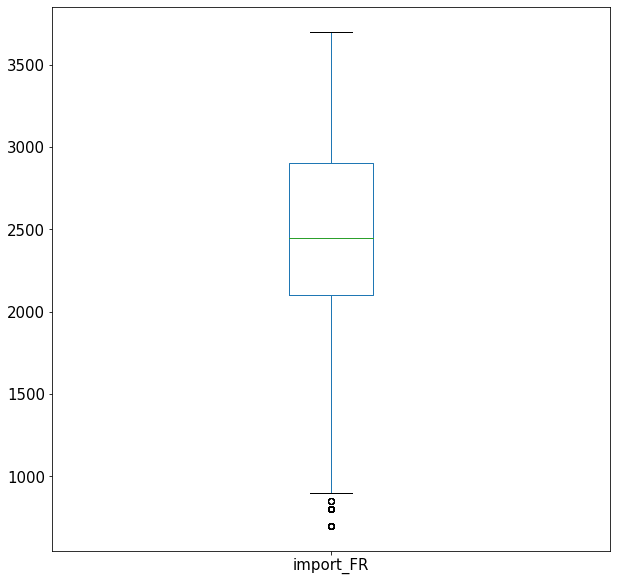

Analyzing outliers of column: export_FR
539 outliers clipped


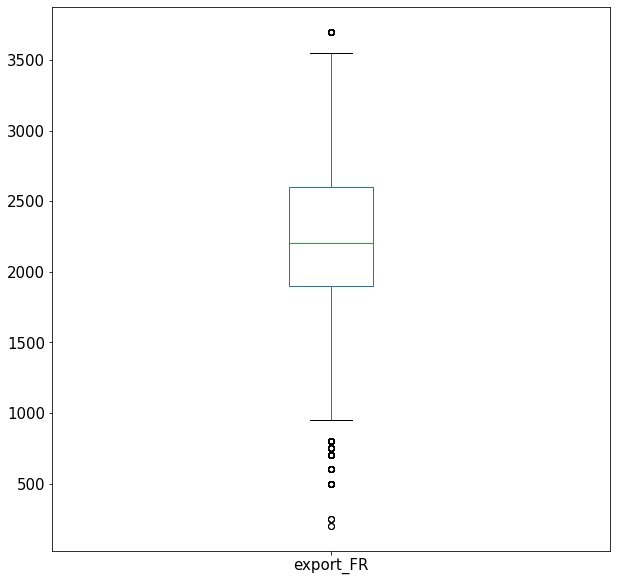

Analyzing outliers of column: fc_wind
347 outliers clipped


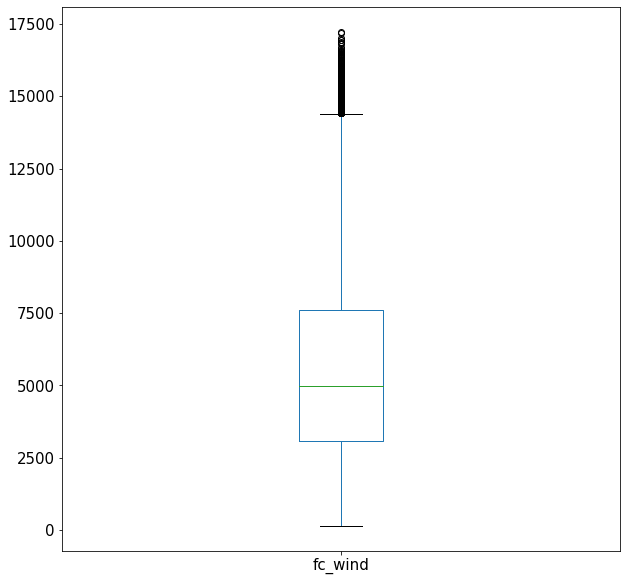

Analyzing outliers of column: fc_solar_pv
842 outliers clipped


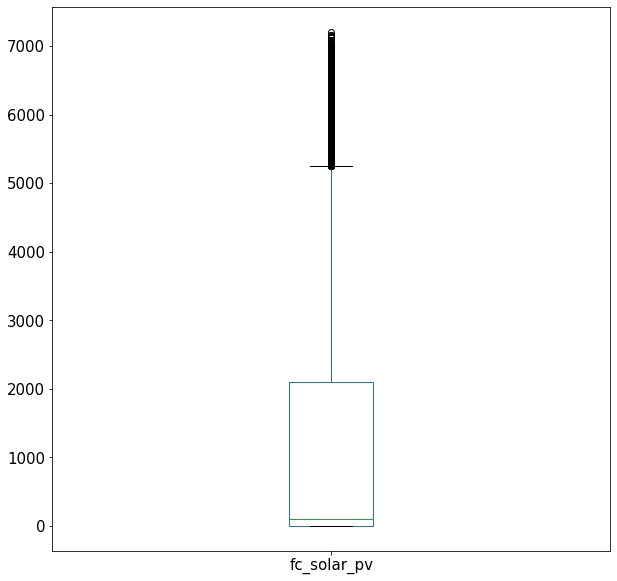

Analyzing outliers of column: fc_solar_th
0 outliers clipped


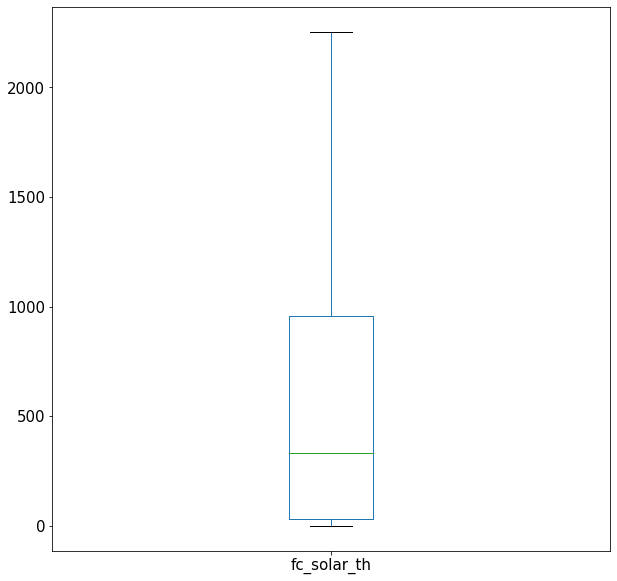

Analyzing outliers of column: price
690 outliers clipped


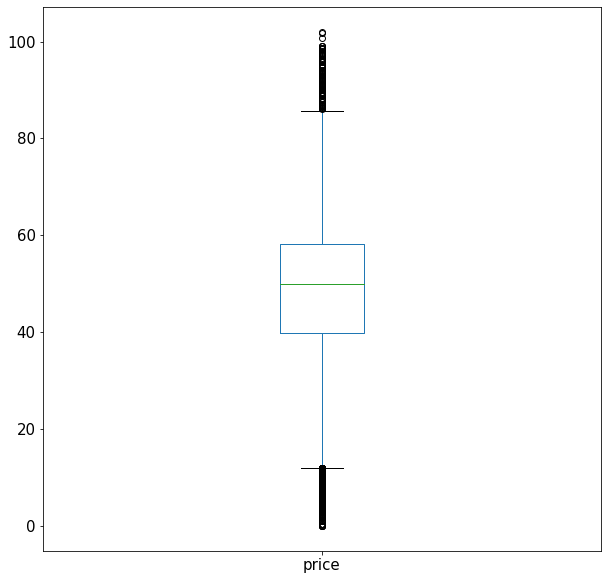

Analyzing outliers of column: hour
0 outliers clipped


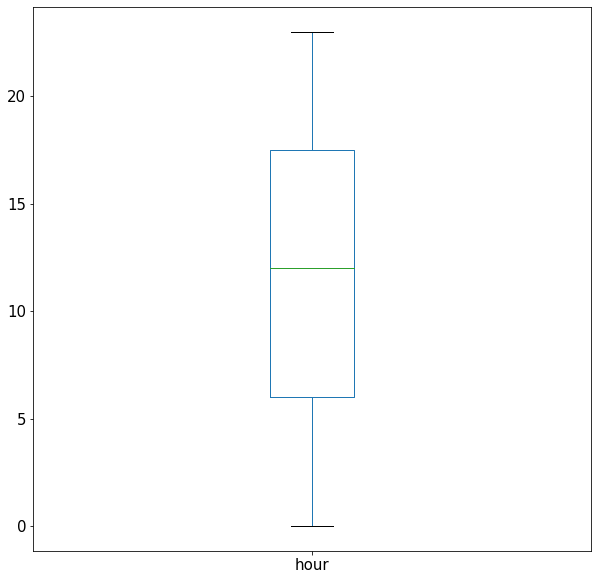

In [13]:
for (columnName, _) in pm_df_clipped.iteritems():
    if pm_df_clipped[columnName].dtype in ['int64','float64']: 
        print("Analyzing outliers of column: {}".format(columnName))
        plt.figure(figsize=(10,10))
        pm_df_clipped.boxplot([columnName], grid=False, fontsize=15)
        pm_df_clipped = clip_outliers(pm_df_clipped,columnName)
        plt.show()

In [14]:
len(pm_df_clipped)

32135

## Feature Engineering

In [15]:
#Choosing between Outlier Treatment (we tested for both and obtained better results for most models by clipping outlier values)
#Furthermore, clipping outliers allows us to preserve more data and time structure as well as make us of lagged variables in a more straightforward fashion.

#pm_df = pm_df_no_outliers
pm_df = pm_df_clipped

In [16]:
#Preliminary feature engeneering: 

#Combining solar energies:
pm_df['fc_solar'] = pm_df['fc_solar_th'] + pm_df['fc_solar_pv'] 

#Creating the aforementioned Thermal Gap:
pm_df['Thermal_Gap'] = pm_df['fc_demand'] - pm_df['fc_nuclear'] - pm_df['fc_wind'] - pm_df['fc_solar']

#Creating Energy Trade Balance SPAIN/FR
pm_df['BoT_FR'] = pm_df['export_FR'] - pm_df['import_FR']
pm_df.head(5)

fc_demand  fc_nuclear  import_FR  export_FR  fc_wind  fc_solar_pv  \
0    24400.0      7117.2     3000.0     2600.0   1732.0          0.0   
1    23616.0      7117.2     3000.0     2650.0   1826.0          0.0   
2    21893.0      7117.2     3000.0     2650.0   1823.0          0.0   
3    20693.0      7117.2     3000.0     2650.0   1777.0          0.0   
4    19599.0      7117.2     3000.0     2650.0   1746.0          0.0   

   fc_solar_th  price        date  hour  fc_solar  Thermal_Gap  BoT_FR  
0          5.1  58.82  2017-01-01   0.0       5.1      15545.7  -400.0  
1          0.6  58.23  2017-01-01   1.0       0.6      14672.2  -350.0  
2          4.6  51.95  2017-01-01   2.0       4.6      12948.2  -350.0  
3          9.7  47.27  2017-01-01   3.0       9.7      11789.1  -350.0  
4         24.1  45.49  2017-01-01   4.0      24.1      10711.7  -350.0

In [17]:
pm_df = pm_df.drop(columns = ['import_FR','export_FR','fc_solar_pv','fc_solar_th'], axis = 1)
pm_df.head(5)

fc_demand  fc_nuclear  fc_wind  price        date  hour  fc_solar  \
0    24400.0      7117.2   1732.0  58.82  2017-01-01   0.0       5.1   
1    23616.0      7117.2   1826.0  58.23  2017-01-01   1.0       0.6   
2    21893.0      7117.2   1823.0  51.95  2017-01-01   2.0       4.6   
3    20693.0      7117.2   1777.0  47.27  2017-01-01   3.0       9.7   
4    19599.0      7117.2   1746.0  45.49  2017-01-01   4.0      24.1   

   Thermal_Gap  BoT_FR  
0      15545.7  -400.0  
1      14672.2  -350.0  
2      12948.2  -350.0  
3      11789.1  -350.0  
4      10711.7  -350.0

In [18]:
#Converting dataframe series "date" into datetime to use dt. functionalities:
pm_df['date'] = pd.to_datetime(pm_df['date'])

# Adding additional columns with year & day of the year:
pm_df['Year'] = pm_df['date'].dt.year
pm_df['Day_of_Year'] = pm_df['date'].dt.dayofyear
pm_df.head(5)

fc_demand  fc_nuclear  fc_wind  price       date  hour  fc_solar  \
0    24400.0      7117.2   1732.0  58.82 2017-01-01   0.0       5.1   
1    23616.0      7117.2   1826.0  58.23 2017-01-01   1.0       0.6   
2    21893.0      7117.2   1823.0  51.95 2017-01-01   2.0       4.6   
3    20693.0      7117.2   1777.0  47.27 2017-01-01   3.0       9.7   
4    19599.0      7117.2   1746.0  45.49 2017-01-01   4.0      24.1   

   Thermal_Gap  BoT_FR  Year  Day_of_Year  
0      15545.7  -400.0  2017            1  
1      14672.2  -350.0  2017            1  
2      12948.2  -350.0  2017            1  
3      11789.1  -350.0  2017            1  
4      10711.7  -350.0  2017            1

In [19]:
pm_df['weekend'] = pm_df['date'].dt.dayofweek
pm_df.head(5)

fc_demand  fc_nuclear  fc_wind  price       date  hour  fc_solar  \
0    24400.0      7117.2   1732.0  58.82 2017-01-01   0.0       5.1   
1    23616.0      7117.2   1826.0  58.23 2017-01-01   1.0       0.6   
2    21893.0      7117.2   1823.0  51.95 2017-01-01   2.0       4.6   
3    20693.0      7117.2   1777.0  47.27 2017-01-01   3.0       9.7   
4    19599.0      7117.2   1746.0  45.49 2017-01-01   4.0      24.1   

   Thermal_Gap  BoT_FR  Year  Day_of_Year  weekend  
0      15545.7  -400.0  2017            1        6  
1      14672.2  -350.0  2017            1        6  
2      12948.2  -350.0  2017            1        6  
3      11789.1  -350.0  2017            1        6  
4      10711.7  -350.0  2017            1        6

In [20]:
#defining function to assign to value 5,6 in weekdays value 1 for weekend
def weekend(x):
    if x in [5,6]:
        return 1
    else:
        return 0

In [21]:
#Replacing values in column weekdays with 1 and 0 values 
pm_df['weekend'].replace({1:0})

0        6
1        6
2        6
3        6
4        6
        ..
32130    0
32131    0
32132    0
32133    0
32134    0
Name: weekend, Length: 32135, dtype: int64

In [22]:
#applying the function weekend to the column weekdays in our dataset
pm_df['weekend'] = pm_df['weekend'].apply(weekend)
pm_df.head(5)

fc_demand  fc_nuclear  fc_wind  price       date  hour  fc_solar  \
0    24400.0      7117.2   1732.0  58.82 2017-01-01   0.0       5.1   
1    23616.0      7117.2   1826.0  58.23 2017-01-01   1.0       0.6   
2    21893.0      7117.2   1823.0  51.95 2017-01-01   2.0       4.6   
3    20693.0      7117.2   1777.0  47.27 2017-01-01   3.0       9.7   
4    19599.0      7117.2   1746.0  45.49 2017-01-01   4.0      24.1   

   Thermal_Gap  BoT_FR  Year  Day_of_Year  weekend  
0      15545.7  -400.0  2017            1        1  
1      14672.2  -350.0  2017            1        1  
2      12948.2  -350.0  2017            1        1  
3      11789.1  -350.0  2017            1        1  
4      10711.7  -350.0  2017            1        1

In [23]:
# Creating a new column, to determine whether the day is a public holiday
# First checkin min and max date to understand the exact range of dates we have to look at:
print(pm_df.date.min())
print(pm_df.date.max())

# So now tedious work time! Time to identify public holidays in Spain from jan 2017 to sept 2020
# Sources: 
# 2017: https://calendarios.ideal.es/2017
# 2018: https://calendarios.ideal.es/2018
# 2019: https://calendarios.ideal.es/2019
# 2020: https://calendarios.ideal.es/2020
festivos = ['2017-01-06','2017-03-13','2017-03-02','2017-03-14','2017-05-01','2017-08-15','2017-10-12','2017-11-01','2017-12-06','2017-12-08','2017-12-25','2018-01-01','2018-01-06','2018-03-30','2018-04-02','2018-05-01','2018-08-15','2018-10-12','2018-11-01','2018-12-06','2018-12-08','2018-12-25','2019-01-01','2019-04-02','2019-04-19','2019-05-01','2019-08-15','2019-10-12','2019-11-01','2019-12-06','2019-12-25','2020-01-01','2020-01-06','2020-04-02','2020-04-10','2020-05-01','2020-08-15']
festivosdate = pd.to_datetime(festivos)

print(festivosdate)

2017-01-01 00:00:00
2020-08-31 00:00:00
DatetimeIndex(['2017-01-06', '2017-03-13', '2017-03-02', '2017-03-14',
               '2017-05-01', '2017-08-15', '2017-10-12', '2017-11-01',
               '2017-12-06', '2017-12-08', '2017-12-25', '2018-01-01',
               '2018-01-06', '2018-03-30', '2018-04-02', '2018-05-01',
               '2018-08-15', '2018-10-12', '2018-11-01', '2018-12-06',
               '2018-12-08', '2018-12-25', '2019-01-01', '2019-04-02',
               '2019-04-19', '2019-05-01', '2019-08-15', '2019-10-12',
               '2019-11-01', '2019-12-06', '2019-12-25', '2020-01-01',
               '2020-01-06', '2020-04-02', '2020-04-10', '2020-05-01',
               '2020-08-15'],
              dtype='datetime64[ns]', freq=None)


In [24]:
pm_df['holiday'] = pm_df['date'].isin(festivosdate)
pm_df.holiday.unique()

array([False,  True])

In [25]:
# That however returs True vs False, which is harder to use in a model, so we are recoding them to 1 and 0:
def holiday(x):
    if x == True:
        return 1
    else:
        return 0
    
pm_df['holiday'] = pm_df['holiday'].apply(holiday)

In [26]:
# Checking if the function was implemented correctly
pm_df.sort_values('holiday')

fc_demand  fc_nuclear  fc_wind  price       date  hour  fc_solar  \
0        24400.0      7117.2   1732.0  58.82 2017-01-01   0.0       5.1   
21318    22141.0      6022.1   3559.0  43.99 2019-06-08   7.0     498.9   
21317    21621.0      6022.1   3335.0  43.57 2019-06-08   6.0     396.6   
21316    21738.0      5797.1   3150.0  43.53 2019-06-08   5.0     527.8   
21315    22027.0      5797.1   3114.0  43.58 2019-06-08   4.0     583.7   
...          ...         ...      ...    ...        ...   ...       ...   
17371    25410.0      5976.1   2396.0  66.70 2018-12-25  19.0      16.0   
17372    26380.0      5976.1   2400.0  67.65 2018-12-25  20.0       9.0   
17373    26830.0      5976.1   2556.0  68.70 2018-12-25  21.0       8.5   
17365    24700.0      5776.1   1409.0  66.58 2018-12-25  13.0    2155.7   
16067    27551.0      6105.9   3194.0  64.46 2018-11-01  11.0    3828.1   

       Thermal_Gap  BoT_FR  Year  Day_of_Year  weekend  holiday  
0          15545.7  -400.0  2017            1        1        0  
21318      12061.0   800.0  2019          159        1        0  
21317      11867.3   800.0  2019          159        1        0  
21316      12263.1   800.0  2019          159        1        0  
21315      12532.2   800.0  2019          159        1        0  
...            ...     ...   ...          ...      ...      ...  
17371      17021.9  -950.0  2018          359        0        1  
17372      17994.9  -950.0  2018          359        0        1  
17373      18289.4   200.0  2018          359        0        1  
17365      15359.2  1150.0  2018          359        0        1  
16067      14423.0   350.0  2018          305        0        1  

[32135 rows x 13 columns]

In [27]:
#Adding a feature for COVID_PERIOD with values 0 and 1 translating whether the day was during Covid-19 lockdown period or not
#The first lockdown in Spain started on 14-March-2020
import datetime
pm_df['covid_period'] = pm_df.apply(lambda row:1 if row['date']>=datetime.date(2020, 3, 14) else 0,axis =1)
#Additionally, we also decided to create a variable to model the hard lockdown since it is likely energy prices fluctuated more due to the temporary ceasure of many business activties.
pm_df['hard_lockdown'] = pm_df.apply(lambda row:1 if datetime.date(2020, 3, 14) <= row['date'] <= datetime.date(2020, 6, 21) else 0,axis =1)

In [28]:
#Computing price_lags:
pm_df['price_lag_hourly']=pm_df['price'].diff()
pm_df['price_lag_daily']=pm_df['price'].diff(periods=24)

In [29]:
#Compute Thermal_Gap_lags (we are unable to use price lags given the scoring dataset so decided to try and include Thermal_gap 
#lags to capture the effect of past information on price since this variable is highly correlated with price):
pm_df['thermal_gap_lag_hourly']=pm_df['Thermal_Gap'].diff()
pm_df['thermal_gap_daily']=pm_df['Thermal_Gap'].diff(periods=24)

In [30]:
pm_df = pm_df.drop(columns = ['date'], axis = 1)
pm_df.head(12)

fc_demand  fc_nuclear  fc_wind  price  hour  fc_solar  Thermal_Gap  \
0     24400.0      7117.2   1732.0  58.82   0.0       5.1      15545.7   
1     23616.0      7117.2   1826.0  58.23   1.0       0.6      14672.2   
2     21893.0      7117.2   1823.0  51.95   2.0       4.6      12948.2   
3     20693.0      7117.2   1777.0  47.27   3.0       9.7      11789.1   
4     19599.0      7117.2   1746.0  45.49   4.0      24.1      10711.7   
5     19211.0      7117.2   1662.0  44.50   5.0      30.4      10401.4   
6     19314.0      7117.2   1684.0  44.50   6.0      40.0      10472.8   
7     19538.0      7117.2   1780.0  44.72   7.0      45.5      10595.3   
8     19651.0      7117.2   1803.0  44.22   8.0      99.7      10631.1   
9     20066.0      7117.2   1737.0  45.13   9.0     562.9      10648.9   
10    22001.0      7117.2   1562.0  46.23  10.0    1377.3      11944.5   
11    23417.0      7117.2   1433.0  47.91  11.0    2056.2      12810.6   

    BoT_FR  Year  Day_of_Year  weekend  holiday  covid_period  hard_lockdown  \
0   -400.0  2017            1        1        0             0              0   
1   -350.0  2017            1        1        0             0              0   
2   -350.0  2017            1        1        0             0              0   
3   -350.0  2017            1        1        0             0              0   
4   -350.0  2017            1        1        0             0              0   
5   -350.0  2017            1        1        0             0              0   
6   -350.0  2017            1        1        0             0              0   
7   -350.0  2017            1        1        0             0              0   
8   -350.0  2017            1        1        0             0              0   
9   -350.0  2017            1        1        0             0              0   
10  -350.0  2017            1        1        0             0              0   
11  -350.0  2017            1        1        0             0              0   

    price_lag_hourly  price_lag_daily  thermal_gap_lag_hourly  \
0                NaN              NaN                     NaN   
1              -0.59              NaN                  -873.5   
2              -6.28              NaN                 -1724.0   
3              -4.68              NaN                 -1159.1   
4              -1.78              NaN                 -1077.4   
5              -0.99              NaN                  -310.3   
6               0.00              NaN                    71.4   
7               0.22              NaN                   122.5   
8              -0.50              NaN                    35.8   
9               0.91              NaN                    17.8   
10              1.10              NaN                  1295.6   
11              1.68              NaN                   866.1   

    thermal_gap_daily  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  
5                 NaN  
6                 NaN  
7                 NaN  
8                 NaN  
9                 NaN  
10                NaN  
11                NaN

In [33]:
pm_df = pm_df.iloc[24:] #dropping first rows of thermal_gap_hourly & price_lag_hourly and drop first 24 rows of price_lag_daily , thermal_gap_daily since they're Null Values.

#### Comments

From the Pandas profiling, we can see that, after feature engineering, we have 19 variables, 14 of them numberic and 5 categorical. The total number of observations is now  28048, with 0 values missing.
- df_index: this variable is an index to reference each row. 
- fc_demand: the demand variable varies quite a lot between the minimum and maximum value going from 16372 to 40699. When looking at the distribution of the variable, we can clearly see that the distribution is not normal but the amount of the demand tends to vary. As we know from previous research, demand has an important effect on pricing, so we would expect that whenever the demand changes drastically, we would see a big change in pricing as well.
- fc_nuclear: for nuclear we have values ranging from 4515.2 to 7117.2. When looking at the distribution, we can see that the most frequent value is the maximum value with 7117.2 (has a frequency of 53.2%) and the least around the 5500.
- fc_wind: the variable has a minimum of 139 and a maximum of 14413. The distribution is skewed to the right (skewness of 0.669) showing less production to be more frequent. This is reflected also in the mean= 5590.40.
- fc_solar: the variable has a minimum of 0 and a maximum 7183.7. The zero's here represent a big part of the values (267 in total). This is also suggested by the power law distribution that the data seems to follow. The amount of zeros are probably due to the impossibility of getting solar energy during the night and the restricted amount of light during winter
- price: main drivers seem to be Thermal Gap and fc_demand. Since the latter two are also highly correlated with each , we will only include one in the model (Thermal Gap given its higher correlation coefficient). We observe it also exhibits a low positive correlation with price_lag_daily , price_lag_hourly, hour and Day_of_Year and a negative low correlation with Year, weekend, BoT_FR and fc_wind. Price has a minimum of 13.3 and a maximum of 85.5. The distibution is fairly simmetrycal (skewness of -0.21). The average price is around 49 euros with the most frequent value being 50 euros.
- Thermal_Gap: the variable has a minimum value of 302.4 and a maximum of 30643 and a mean of 14931.56. The distribution seems to be normal. 
- hour: the variable expresses the hour of the day. For each day, we have 24 values for hour. After performing feature engineering our maximum value is 23, meaning we do not have data for midnight in the dataset. This is also why the distribution is not uniform anymore, as we deleted some data for the hours 10, 11, 12, 13, 14, 15, 16, 17 and 18. 
- BoT_FR: the variable has a minimum value of -2300 and a maximum of 2100 and a mean of -220.02. The distribution is fairly simmetrycal (skewness 0.399). We can see from the distribution that the amount of the BoT_FR varies a lot. This makes sense as everyday according to a surplus or deficit in energy, we will have a different value for BoT_FR.
- Year: the variable has been extrapolated from the date column in the original dataframe. The variable just has the years each data point refers to and it is a categorical feature. This is going to be useful for our analysis later on. As this dataset covers 4 years (from 2018 to 2020), the variable only has 4 categories. 
- Day_of_Year: this is another variables extrapolated from the original column date. Here we look at the days of the year. We have a minimum value of 1 (for day 1 of the Year) and a maximum value of 365 (for the last day of the year). The distribution is not uniform as some values have been removed during the feature engineering. 
- weekend: this is a categorical variable created to capture the days in a year that are workdays (defined by a value 0) and the weekends (defined by a value 1)
- holiday: this is a categorical variable created to capture the days of holidays in a year  (defined by a value 1). 
- price_lag_hourly: this is a new variable created to understand which hour lags affect the price of energy. The minimum value is -26.18 and the maximum 34.33. The distribution is normal and this is also suggested by the mean of -0.0002 and skewness of 0.58.
- price_lag_daily: this is another variable created to understand which daily lag and how many affect the price of energy. The minimum value is -49.4 and the maximum 44.56. The distribution is fairly simmetrycal as depicted by a skewness value of 0.11. The mean for the variable is -0.009. This variable will be useful to calculate our ARIMA model.
- covid_period: the variable is categorical taking on values 1 or 0. The variable represents the period of time when covid started and it was extracted from date. We considered the Covid period to have started on the 14/03/2020
- hard lockdown: The variable is categorical taking on values 1 or 0. The variable represents the period of time the Spanish goverment declared the national hard lockdown. The variable was extracted from data and considers the period from thw 14/03/2020 until the 21/06/2020. 
- thermal_gap_daily: the variable is numerical and considers the daily lags in thermal gap. The variable has a minimum of -14719.7 and a maximum of 17726.5. When looking at the distribution of the variable, it seems to be fairly simmetrycal (skewness of 0.234). The mean of the variable is -0.805. This variable is going to be useful to capture information from the past about the thermal gap. 
- thermal_gap_lag_hourly: the variable is numerical and considers hourly lags in thermal gap. The variable has a minimum of -4131.7 and a maximum of 5860.4. The mean is 0.03. the distribution is fairly simmetrycal with a skewness of 0.508. The explanaroty feature has been created to capture the hourly past influence of thermal gap into the future for our model. 

Interactions:
- fc_demand and hour: When looking at the interactions between fc_demand and hour, we can clearly see that during the first hours of the day the demand for energy is very low. This makes sense as most people are sleeping.
- fc_demand and fc_wind: we confirm the low demand for wind energy
- fc_demand and Thermal_Gap: we can see that has demand goes up, Thermal_Gap also increases. This makes sense as Thermal_Gap represents the remaining demand after subtracting the predicted energy produced.
- fc_demand and BoT_FR: we can see that when demand is low, BoT_FR increases (as there are more resources for export), and when demand for resources goes up, BoT_FR decreases as less energy is avaialable for export.
- fc_demand and price: the variables are interacting as demand increases, prices for energy increases as well
- price and Thermal_Gap: as the thermal gap increases, the price increases 


Pearson's Correlation:
- fc_demand and hours: the variables seem to be very correlated as the time of the day will impact the consumption and therefore demand of energy (during the night the demand would fall as people are sleeping)
- fc_demand and price: the variables are correlated as the demand of energy has a direct impact on the price that the energy will have
- fc_demand and Thermal_Gap: the two variables are correlated as we can see that as demand goes up, Thermal_Gap also increases. This makes sense as Thermal_Gap represents the remaining demand after subtracting the predicted energy produced.
- Thermal_Gap and fc_wind: the two variables are correlated. In fact, as wind energy decreases, the Thermal Gap increases, given the formula to calculate the Thermal Gap.
- Thermal_Gap and weekend: the two variables seem to be correlated. The correlation suggests that when it is a wekeend, the Thermal_Gap decreases, as probably people spend more energy cooking or being home with their families.
- price and Thermal_Gap: the two variables are correlated. As the thermal gap increases, the price increases 
- price and Year: the two variables seems to be correlated. This correlation would suggest that has Year increases, the price decreases.
- thermal_gap_daily and weekend: the two variables are inversively correlated. When weekend is 1, meaning it is a weekend day,  the thermal_gap_daily seems to be going down. 
- covid and price: the two variables are inversively correlated. When covid happened the price for energy went down. Such assumption makes sense as manufactures, shops, restuarants and offices were closed, not consuming any energy. 
- hard_lockdown and price: the two variables are inversively correlated. When the hard lockdown happened the price for energy went down. Such assumption makes sense as manufactures, shops, restuarants and offices were closed, not consuming any energy


## Data Standardization (if required)

In [34]:
#Creating a dataset with all variables standardized ((X-mu)/sigma)) in order to feed it to specific algorithms that require such
#pre-processing procedure (e.g. SVR).
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(pm_df)
standard_pm_df = scaler.transform(pm_df)
standard_pm_df = pd.DataFrame(data = standard_pm_df, index = None , columns = pm_df.columns)
standard_pm_df.head(12)

fc_demand  fc_nuclear   fc_wind     price      hour  fc_solar  \
0   -0.290698    0.819699 -0.513498  0.425968 -1.661390 -0.832513   
1   -0.786961    0.819699 -0.524298  0.292467 -1.516925 -0.832314   
2   -1.106277    0.819699 -0.555464  0.052301 -1.372460 -0.832314   
3   -1.227301    0.819699 -0.524298 -0.240163 -1.227995 -0.832613   
4   -1.267429    0.819699 -0.598664 -0.227777 -1.083530 -0.832015   
5   -1.134025    0.819699 -0.641863  0.052301 -0.939065 -0.832164   
6   -0.651850    0.819699 -0.603601  0.630350 -0.794600 -0.832314   
7    0.142384    0.819699 -0.596195  1.515314 -0.650135 -0.832164   
8    0.837152    0.819699 -0.673646  1.591011 -0.505670 -0.808841   
9    1.348996    0.819699 -0.735668  1.665331 -0.361205 -0.626546   
10   1.652517    0.819699 -0.743691  1.709373 -0.216740 -0.351359   
11   1.628184    0.819699 -0.880079  1.707996 -0.072275 -0.101238   

    Thermal_Gap    BoT_FR      Year  Day_of_Year   weekend   holiday  \
0      0.256123 -0.237145 -1.279716    -1.651612 -0.632421 -0.168708   
1     -0.200244 -0.168852 -1.279716    -1.651612 -0.632421 -0.168708   
2     -0.478200 -0.168852 -1.279716    -1.651612 -0.632421 -0.168708   
3     -0.611181 -0.168852 -1.279716    -1.651612 -0.632421 -0.168708   
4     -0.600860 -0.168852 -1.279716    -1.651612 -0.632421 -0.168708   
5     -0.448372 -0.168852 -1.279716    -1.651612 -0.632421 -0.168708   
6     -0.022909 -0.783483 -1.279716    -1.651612 -0.632421 -0.168708   
7      0.713666 -0.237145 -1.279716    -1.651612 -0.632421 -0.168708   
8      1.402919 -0.237145 -1.279716    -1.651612 -0.632421 -0.168708   
9      1.847889 -0.237145 -1.279716    -1.651612 -0.632421 -0.168708   
10     2.026379 -0.237145 -1.279716    -1.651612 -0.632421 -0.168708   
11     1.991729 -0.237145 -1.279716    -1.651612 -0.632421 -0.168708   

    covid_period  hard_lockdown  price_lag_hourly  price_lag_daily  \
0      -0.382909      -0.284266         -1.353382        -0.040246   
1      -0.382909      -0.284266         -0.640306         0.349460   
2      -0.382909      -0.284266         -1.152004         0.293788   
3      -0.382909      -0.284266         -1.402902        -0.104065   
4      -0.382909      -0.284266          0.059565         0.027647   
5      -0.382909      -0.284266          1.343762         0.320945   
6      -0.382909      -0.284266          2.773216         1.008023   
7      -0.382909      -0.284266          4.245586         1.555241   
8      -0.382909      -0.284266          0.363282         0.902110   
9      -0.382909      -0.284266          0.356680         1.043327   
10     -0.382909      -0.284266          0.211424         0.659053   
11     -0.382909      -0.284266         -0.006461         0.995802   

    thermal_gap_lag_hourly  thermal_gap_daily  
0                -2.071042           1.016536  
1                -1.620371           1.028132  
2                -0.986886           0.954114  
3                -0.472117           0.866908  
4                 0.036709           0.845433  
5                 0.541502           0.842919  
6                 1.510762           0.783909  
7                 2.615435           0.903930  
8                 2.447406           1.199773  
9                 1.580025           1.261811  
10                0.633830           1.082652  
11               -0.122971           1.022462

In [35]:
len(standard_pm_df)

32087

In [36]:
standard_pm_df.head(5)

fc_demand  fc_nuclear   fc_wind     price      hour  fc_solar  Thermal_Gap  \
0  -0.290698    0.819699 -0.513498  0.425968 -1.661390 -0.832513     0.256123   
1  -0.786961    0.819699 -0.524298  0.292467 -1.516925 -0.832314    -0.200244   
2  -1.106277    0.819699 -0.555464  0.052301 -1.372460 -0.832314    -0.478200   
3  -1.227301    0.819699 -0.524298 -0.240163 -1.227995 -0.832613    -0.611181   
4  -1.267429    0.819699 -0.598664 -0.227777 -1.083530 -0.832015    -0.600860   

     BoT_FR      Year  Day_of_Year   weekend   holiday  covid_period  \
0 -0.237145 -1.279716    -1.651612 -0.632421 -0.168708     -0.382909   
1 -0.168852 -1.279716    -1.651612 -0.632421 -0.168708     -0.382909   
2 -0.168852 -1.279716    -1.651612 -0.632421 -0.168708     -0.382909   
3 -0.168852 -1.279716    -1.651612 -0.632421 -0.168708     -0.382909   
4 -0.168852 -1.279716    -1.651612 -0.632421 -0.168708     -0.382909   

   hard_lockdown  price_lag_hourly  price_lag_daily  thermal_gap_lag_hourly  \
0      -0.284266         -1.353382        -0.040246               -2.071042   
1      -0.284266         -0.640306         0.349460               -1.620371   
2      -0.284266         -1.152004         0.293788               -0.986886   
3      -0.284266         -1.402902        -0.104065               -0.472117   
4      -0.284266          0.059565         0.027647                0.036709   

   thermal_gap_daily  
0           1.016536  
1           1.028132  
2           0.954114  
3           0.866908  
4           0.845433

## Feature Selection

Based on the previous analysis about the variable's correlation matrix, we decided to consider ['Thermal_Gap', 'fc_wind' , 'fc_solar', 'BoT_FR' , 'holiday' , 'hour', 'weekend' , 'thermal_gap_daily', 'covid_period', 'hard_lockdown']] as preliminary features for our model.

## Time Series Dataset Splitting (train/test)

#### 1. Test Set - Using the last 20% of the dataset

In [37]:
from sklearn.model_selection import train_test_split , TimeSeriesSplit

# price is the target variable
X = pm_df.loc[:,['Thermal_Gap', 'fc_wind' , 'fc_solar', 'BoT_FR' , 'holiday' , 'hour', 'weekend' , 'thermal_gap_daily', 'covid_period', 'hard_lockdown']]
y = pm_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 , shuffle=False) #shuffle = False means we remove data in orderly fashion

In [38]:
X_test

Thermal_Gap  fc_wind  fc_solar  BoT_FR  holiday  hour  weekend  \
25717      15475.2   3229.0    3020.9     0.0        0  13.0        1   
25718      15523.7   3570.0    2720.4     0.0        0  14.0        1   
25719      14023.8   4115.0    2312.3     0.0        0  15.0        1   
25720      14061.3   4394.0    1399.8     0.0        0  16.0        1   
25721      14875.6   4956.0     391.5     0.0        0  17.0        1   
...            ...      ...       ...     ...      ...   ...      ...   
32130      15218.4   2846.0    3650.4  -450.0        0  19.0        0   
32131      18131.7   2861.0    1343.1  -450.0        0  20.0        0   
32132      20026.3   2859.0     682.5  -450.0        0  21.0        0   
32133      18212.5   2771.0     598.3  -450.0        0  22.0        0   
32134      16191.0   2746.0     617.8  -450.0        0  23.0        0   

       thermal_gap_daily  covid_period  hard_lockdown  
25717            -2623.0             0              0  
25718            -2245.7             0              0  
25719            -2899.2             0              0  
25720            -3263.9             0              0  
25721            -4629.3             0              0  
...                  ...           ...            ...  
32130             9953.1             1              0  
32131            10280.9             1              0  
32132             9197.1             1              0  
32133             7631.9             1              0  
32134             6751.7             1              0  

[6418 rows x 10 columns]

#### 2. Test Set - Using TimeSeries Split

In [39]:
# Infering number of splits --> Attempt of adjusting our models predictions on a daily basis. This "learning as you go" approach can sometimes lead to some data leakage.
required_splits = (len(pm_df.index)/24)
print(required_splits)

1336.9583333333333


In [40]:
tss = TimeSeriesSplit(n_splits = 1338)
print(tss)

TimeSeriesSplit(max_train_size=None, n_splits=1338)


In [41]:
for train_index, test_index in tss.split(X):
    Tss_X_train, Tss_X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    Tss_y_train, Tss_y_test = y.iloc[train_index], y.iloc[test_index]

In [42]:
Tss_X_test

Thermal_Gap  fc_wind  fc_solar  BoT_FR  holiday  hour  weekend  \
32112     6915.100   6601.0   545.700  -300.0        0   1.0        0   
32113     6539.000   6259.0   455.800  -300.0        0   2.0        0   
32114     6410.400   5886.0   468.400  -300.0        0   3.0        0   
32115     7190.200   5382.0   405.600  -300.0        0   4.0        0   
32116     8028.000   5193.0   313.800  -300.0        0   5.0        0   
32117    10326.600   4996.0   213.200  -300.0        0   6.0        0   
32118    12575.400   4720.0   137.400  -300.0        0   7.0        0   
32119    14118.900   4225.0  1163.900  -450.0        0   8.0        0   
32120    13816.300   3460.0  3936.500  -450.0        0   9.0        0   
32121    12011.500   3471.0  6826.300  -450.0        0  10.0        0   
32122    12664.125   3258.0  7207.675  -450.0        0  11.0        0   
32123    13616.225   2905.0  7311.575  -450.0        0  12.0        0   
32124    14378.425   2696.0  7348.375  -450.0        0  13.0        0   
32125    14202.525   2596.0  7292.275  -450.0        0  14.0        0   
32126    13228.925   2548.0  7147.875  -450.0        0  15.0        0   
32127    12760.625   2508.0  7269.175  -450.0        0  16.0        0   
32128    12551.625   2606.0  7298.175  -450.0        0  17.0        0   
32129    13407.500   2716.0  6094.300  -450.0        0  18.0        0   
32130    15218.400   2846.0  3650.400  -450.0        0  19.0        0   
32131    18131.700   2861.0  1343.100  -450.0        0  20.0        0   
32132    20026.300   2859.0   682.500  -450.0        0  21.0        0   
32133    18212.500   2771.0   598.300  -450.0        0  22.0        0   
32134    16191.000   2746.0   617.800  -450.0        0  23.0        0   

       thermal_gap_daily  covid_period  hard_lockdown  
32112             1082.3             1              0  
32113             1057.9             1              0  
32114              996.9             1              0  
32115             1748.5             1              0  
32116             2162.0             1              0  
32117             4006.2             1              0  
32118             5880.8             1              0  
32119             7820.6             1              0  
32120             8299.8             1              0  
32121             8136.7             1              0  
32122             9046.1             1              0  
32123             9315.5             1              0  
32124             9387.7             1              0  
32125             9095.3             1              0  
32126             8719.2             1              0  
32127             9057.6             1              0  
32128             9643.0             1              0  
32129             9889.5             1              0  
32130             9953.1             1              0  
32131            10280.9             1              0  
32132             9197.1             1              0  
32133             7631.9             1              0  
32134             6751.7             1              0

#### 3. Test Set - Using Block TimeSeriesSplit

In [43]:
#This method helps us make predictions on a rolling basis. The train/test % split and selected amount of splits will determine
#the size of our rolling window (e.g. predicting the next 24 hours with previous 24 hours of data. )

class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.6667 * (stop - start)) + start #splitting 66.7% train / 33.3% test this can be changed according to the desired rationale /number of splits
            yield indices[start: mid], indices[mid + margin: stop]

In [44]:
#Several Options were trying based on the price mechanics of the energy market:
#btss_required_splits = (len(pm_df.index)/(24)) #we wanna predict the next 5 hours based on the 19 hours that preceed it (80/20 split) 
#btss_required_splits = (len(pm_df.index)/(24 * 2)) #we wanna predict the next 24 hours based on the 24hours that preceed it. (50/50 split)
btss_required_splits = (len(pm_df.index)/(24 * 3)) #we wanna predict the next 24 hours based on the 48hours that preceed it. (66.7/33/3 split)
#btss_required_splits = (len(pm_df.index)/(24 * 4)) #we wanna predict the next 24 hours based on the 3 days of data that preceed it. (75/25 split)
#btss_required_splits = (len(pm_df.index)/(24 * 5)) #we wanna predict the next 24 hours based on the 4 days of data that preceed it. (80/20 split)
#btss_required_splits = (len(pm_df.index)/(24 * 8)) #we wanna predict the next 24 hours based on the week of data that preceeds it. (87.5/12.5 split)
print(btss_required_splits)

445.65277777777777


In [45]:
btss = BlockingTimeSeriesSplit(n_splits = 446)

In [46]:
for train_index, test_index in btss.split(X):
    Btss_X_train, Btss_X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    Btss_y_train, Btss_y_test = y.iloc[train_index], y.iloc[test_index]

In [47]:
Btss_X_test

Thermal_Gap  fc_wind  fc_solar  BoT_FR  holiday  hour  weekend  \
31690    16850.125    424.0  7152.675  -200.0        0  11.0        0   
31691    17801.925    499.0  7317.875  -200.0        0  12.0        0   
31692    18553.425    548.0  7360.375  -200.0        0  13.0        0   
31693    17855.425    724.0  7311.375  -200.0        0  14.0        0   
31694    16393.925    972.0  7365.875  -200.0        0  15.0        0   
31695    16012.425   1200.0  7352.375  -200.0        0  16.0        0   
31696    15542.725   1556.0  7321.075  -200.0        0  17.0        0   
31697    14880.100   2023.0  6846.700  -200.0        0  18.0        0   
31698    16074.200   2251.0  4885.600  -200.0        0  19.0        0   
31699    18455.100   2286.0  2151.700  -200.0        0  20.0        0   
31700    20533.900   2238.0   846.900  -200.0        0  21.0        0   
31701    19434.000   2297.0   624.800  -200.0        0  22.0        0   
31702    17145.300   2493.0   610.500  -200.0        0  23.0        0   
31703    15143.700   2797.0   613.100  -200.0        0   0.0        0   
31704    13652.700   2789.0   587.100  -200.0        0   1.0        0   
31705    12730.100   2586.0   550.700  -200.0        0   2.0        0   
31706    12013.900   2655.0   532.900  -200.0        0   3.0        0   
31707    12010.400   2377.0   506.400  -200.0        0   4.0        0   
31708    12576.600   2030.0   418.200  -200.0        0   5.0        0   
31709    14242.800   1855.0   271.000  -200.0        0   6.0        0   
31710    15615.500   1632.0   317.300  -200.0        0   7.0        0   
31711    16504.300   1297.0  1478.500  -200.0        0   8.0        0   
31712    16208.800    867.0  4332.000  -200.0        0   9.0        0   
31713    15236.900    735.0  6917.900  -200.0        0  10.0        0   

       thermal_gap_daily  covid_period  hard_lockdown  
31690           2493.300             1              0  
31691           3123.900             1              0  
31692           3484.300             1              0  
31693           3476.300             1              0  
31694           3854.900             1              0  
31695           4857.300             1              0  
31696           5215.125             1              0  
31697           3499.700             1              0  
31698           2886.200             1              0  
31699           2585.100             1              0  
31700           2111.100             1              0  
31701           1503.200             1              0  
31702            459.600             1              0  
31703           -334.600             1              0  
31704           -918.700             1              0  
31705          -1059.700             1              0  
31706          -1566.900             1              0  
31707          -1291.400             1              0  
31708           -976.000             1              0  
31709           -575.700             1              0  
31710           -488.200             1              0  
31711           -474.600             1              0  
31712           -709.100             1              0  
31713           -768.400             1              0

In [48]:
Btss_X_train.head(5)

Thermal_Gap  fc_wind  fc_solar  BoT_FR  holiday  hour  weekend  \
31643      15352.4   5633.0    5149.4  -200.0        0  12.0        0   
31644      15538.0   6189.0    5461.8  -200.0        0  13.0        0   
31645      13880.4   7070.0    5903.4  -200.0        0  14.0        0   
31646      11811.3   8375.0    5536.5  -200.0        0  15.0        0   
31647      13065.6   7480.0    4747.2  -200.0        0  16.0        0   

       thermal_gap_daily  covid_period  hard_lockdown  
31643             -481.1             1              0  
31644             -128.5             1              0  
31645            -1962.3             1              0  
31646            -2350.3             1              0  
31647             -951.4             1              0

## Models

In [49]:
#Function to visualize feature impotance:
def get_feature_importance(model, feature_names):
    return pd.DataFrame({'variable': feature_names, # Feature names
                         'coefficient': model.coef_[0:] # Feature Coeficients
                    }) \
    .round(decimals=2) \
    .sort_values('coefficient', ascending=False) \
    .style.bar(color=['red', 'green'], align='zero')

In [50]:
#Function to display Cross-Validation Scores
def display_scores(score):
    print("Scores:", scores)
    print("Mean", scores.mean())
    print("Standard Deviation:", scores.std())

#### 1. LR Baseline

In [51]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regressor = LinearRegression()

# Train the model using the training sets
regressor.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regressor.predict(X_test)

# The coefficients
print('Coefficients: \n', regressor.coef_)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % regressor.score(X_train, y_train))
print('Test R-Squared: %.2f' % r2_score(y_test, y_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(y_test, y_pred, squared=False))

Coefficients: 
 [ 1.82323732e-03 -3.14519201e-07 -5.97177059e-04 -7.72134555e-04
  1.08557367e+00 -5.23101340e-02  2.10839715e+00 -9.82361376e-05
  0.00000000e+00  0.00000000e+00]
Train R-Squared: 0.51
Test R-Squared: -2.10
Test RMSE: 17.77


In [52]:
# Defining Table to Summarize Results:
results_df = pd.DataFrame(columns=['Algorithm', 'RMSE'])
results_df.loc[len(results_df)] = ['LR Baseline', mean_squared_error(y_test,regressor.predict(X_test) , squared=False)]
results_df

Algorithm       RMSE
0  LR Baseline  17.767744

In [53]:
get_feature_importance(regressor, X_train.columns) #these coefficients cannot be compared with each other given data is not standardized.

In [54]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.head(5)

Actual  Predicted
25717   42.01  53.837649
25718   42.00  54.016046
25719   38.11  51.536796
25720   38.05  52.133520
25721   41.10  54.301961

#### 2. LR Baseline (TSS)

In [55]:
# Create linear regression object
regressor = LinearRegression(normalize = False)

# Train the model using the training sets
regressor.fit(Tss_X_train, Tss_y_train)

# Make predictions using the testing set
Tss_y_pred = regressor.predict(Tss_X_test)

# The coefficients
print('Coefficients: \n', regressor.coef_)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % regressor.score(Tss_X_train, Tss_y_train))
print('Test R-Squared: %.2f' % r2_score(Tss_y_test, Tss_y_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Tss_y_test, Tss_y_pred, squared=False))

Coefficients: 
 [ 1.88741820e-03  4.94290759e-05 -2.70561258e-04  1.93756139e-04
  1.06551112e+00 -5.70424824e-02  1.76398908e+00 -1.33396902e-04
 -1.23647451e+01 -6.92675729e+00]
Train R-Squared: 0.64
Test R-Squared: -1.14
Test RMSE: 10.47


In [56]:
results_df.loc[len(results_df)] = ['LR Baseline (TSS)', mean_squared_error(Tss_y_test,regressor.predict(Tss_X_test) , squared=False)]
results_df

Algorithm       RMSE
0        LR Baseline  17.767744
1  LR Baseline (TSS)  10.468930

In [57]:
get_feature_importance(regressor, Tss_X_train.columns)

In [58]:
Tss_df = pd.DataFrame({'Actual': Tss_y_test, 'Predicted': Tss_y_pred})
Tss_df.head(5)

Actual  Predicted
32112   30.82  23.696823
32113   28.89  22.940596
32114   28.43  22.627123
32115   29.41  23.933707
32116   34.39  25.418279

#### 3. LR Baseline (BTSS)

In [59]:
# Train the model using the training sets
regressor.fit(Btss_X_train, Btss_y_train)

# Make predictions using the testing set
Btss_y_pred = regressor.predict(Btss_X_test)

# The coefficients
print('Coefficients: \n', regressor.coef_)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % regressor.score(Btss_X_train, Btss_y_train))
print('Test R-Squared: %.2f' % r2_score(Btss_y_test, Btss_y_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Btss_y_test, Btss_y_pred, squared=False))

Coefficients: 
 [ 1.48704070e-03 -9.84573186e-05  2.99008053e-04  1.30104261e-17
  0.00000000e+00  1.86891580e-02  0.00000000e+00 -1.06369437e-03
  0.00000000e+00  0.00000000e+00]
Train R-Squared: 0.83
Test R-Squared: 0.08
Test RMSE: 4.40


In [60]:
results_df.loc[len(results_df)] = ['LR Baseline (BTSS)', mean_squared_error(Btss_y_test,regressor.predict(Btss_X_test) , squared=False)]
results_df

Algorithm       RMSE
0         LR Baseline  17.767744
1   LR Baseline (TSS)  10.468930
2  LR Baseline (BTSS)   4.398897

In [61]:
get_feature_importance(regressor, Btss_X_train.columns)

In [62]:
Btss_df = pd.DataFrame({'Actual': Btss_y_test, 'Predicted': Btss_y_pred})
Btss_df.head(5)

Actual  Predicted
31690   40.29  42.613717
31691   41.93  43.419018
31692   41.74  44.179746
31693   39.99  43.137010
31694   38.09  40.571554

**Comments:** It appears both TSS and BTSS series splits perform better than a non-random train/test split. Given our discoveries regarding the mechanisms behind electricity price forecasts, this is not surprisng and validates our initial findings.

In [63]:
import statsmodels.formula.api as smf

# Fit regression model
results = smf.ols('price ~ Thermal_Gap + fc_wind + fc_solar + BoT_FR + holiday + hour + weekend + thermal_gap_daily + covid_period + hard_lockdown' , data = pm_df).fit()

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     5762.
Date:                Wed, 31 Mar 2021   Prob (F-statistic):               0.00
Time:                        03:45:43   Log-Likelihood:            -1.1491e+05
No. Observations:               32087   AIC:                         2.298e+05
Df Residuals:                   32076   BIC:                         2.299e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            23.1431      0.34

In [64]:
# Fit regression model (with standardised variables to avoid scaling issues has mentioned earlier - see footnote 2). 
#Please note that thet all our coefficients are siginificant the 95% confidence level.
standard_results = smf.ols('price ~ Thermal_Gap + fc_wind + fc_solar + BoT_FR + holiday + hour + weekend + thermal_gap_daily + covid_period + hard_lockdown' , data = standard_pm_df).fit()

# Inspect the results
print(standard_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     5762.
Date:                Wed, 31 Mar 2021   Prob (F-statistic):               0.00
Time:                        03:45:43   Log-Likelihood:                -29032.
No. Observations:               32087   AIC:                         5.809e+04
Df Residuals:                   32076   BIC:                         5.818e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1.665e-16      0.00

#### 4. Ridge Linear Regression (TSS)

##### 4.1. Standardized Variables (in order to allow for regression coefficient comparison)

In [65]:
# Replcate feature selection for standardized dataframe. Just like earlier, price is the target variable.
X_std = standard_pm_df.loc[:,['Thermal_Gap', 'fc_wind' , 'fc_solar', 'BoT_FR' , 'holiday' , 'hour', 'weekend' , 'thermal_gap_daily','covid_period', 'hard_lockdown']]
y_std = standard_pm_df['price']

In [66]:
for train_index, test_index in tss.split(X_std):
    Tss_std_X_train, Tss_std_X_test = X_std.iloc[train_index, :], X_std.iloc[test_index,:]
    Tss_std_y_train, Tss_std_y_test = y_std.iloc[train_index], y_std.iloc[test_index]

In [67]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

ridge_reg = Ridge(alpha = 1, solver = "cholesky")
ridge_reg.fit(Tss_std_X_train, Tss_std_y_train)

ridge_reg_price_pred = ridge_reg.predict(Tss_std_X_test)

# The coefficients
print('Coefficients: \n', ridge_reg.coef_)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % ridge_reg.score(Tss_std_X_train, Tss_std_y_train))
print('Test R-Squared: %.2f' % r2_score(Tss_std_y_test,ridge_reg_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Tss_std_y_test,ridge_reg_price_pred, squared=False))

Coefficients: 
 [ 0.65179432  0.01098931 -0.03736968  0.00975112  0.01202033 -0.02715008
  0.05481733 -0.03577501 -0.28414264 -0.12538466]
Train R-Squared: 0.64
Test R-Squared: -1.14
Test RMSE: 0.72


In [68]:
#results_df.loc[len(results_df)] = ['Ridge LR Standardized (TSS)', mean_squared_error(Tss_std_y_test,ridge_reg.predict(Tss_std_X_test) , squared=False)]
#results_df

In [69]:
get_feature_importance(ridge_reg, Tss_std_X_train.columns) #coefficients can now be compared. We quickly observe that Thermal Gap , weekend and Covid related variables appear to be the most impactful.

In [70]:
Ridge_df = pd.DataFrame({'Actual': Tss_std_y_test, 'Predicted':ridge_reg_price_pred})
Ridge_df.head(5)

Actual  Predicted
32064 -1.215964  -1.706056
32065 -1.348777  -1.758084
32066 -1.380432  -1.779648
32067 -1.312993  -1.689734
32068 -0.970293  -1.587577

In [71]:
#De-standardizing the predicted output
mean = y.iloc[test_index].mean()
std = y.iloc[test_index].std()
Ridge_df_destandardized = Ridge_df.apply(lambda row:((row*std)+mean),axis =1)
Ridge_df_destandardized.head(5)

Actual  Predicted
32064  33.488895  29.904999
32065  32.517670  29.524531
32066  32.286187  29.366845
32067  32.779348  30.024355
32068  35.285409  30.771401

In [72]:
# RMSE(post de-standardising the variables):
print('Test RMSE: %.2f' % mean_squared_error(Tss_y_test, Ridge_df_destandardized.Predicted, squared=False))

Test RMSE: 9.29


In [73]:
results_df.loc[len(results_df)] = ['Ridge LR Standardized (TSS)', mean_squared_error(Tss_y_test, Ridge_df_destandardized.Predicted, squared=False)]
results_df

Algorithm       RMSE
0                  LR Baseline  17.767744
1            LR Baseline (TSS)  10.468930
2           LR Baseline (BTSS)   4.398897
3  Ridge LR Standardized (TSS)   9.294806

##### 4.2. Non-Standardized Variables

In [74]:
ridge_reg = Ridge(alpha = 1, solver = "cholesky")
ridge_reg.fit(Tss_X_train, Tss_y_train)

ridge_reg_price_pred = ridge_reg.predict(Tss_X_test)

# The coefficients
print('Coefficients: \n', ridge_reg.coef_)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % ridge_reg.score(Tss_X_train, Tss_y_train))
print('Test R-Squared: %.2f' % r2_score(Tss_y_test,ridge_reg_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Tss_y_test,ridge_reg_price_pred, squared=False))

Coefficients: 
 [ 1.88754295e-03  4.95386709e-05 -2.70673823e-04  1.93909334e-04
  1.06464989e+00 -5.70630033e-02  1.76402167e+00 -1.33429613e-04
 -1.23605789e+01 -6.92684408e+00]
Train R-Squared: 0.64
Test R-Squared: -1.14
Test RMSE: 10.47


In [75]:
results_df.loc[len(results_df)] = ['Ridge LR (TSS)', mean_squared_error(Tss_y_test,ridge_reg.predict(Tss_X_test) , squared=False)]
results_df

Algorithm       RMSE
0                  LR Baseline  17.767744
1            LR Baseline (TSS)  10.468930
2           LR Baseline (BTSS)   4.398897
3  Ridge LR Standardized (TSS)   9.294806
4               Ridge LR (TSS)  10.466368

In [76]:
get_feature_importance(ridge_reg, Tss_X_train.columns)

In [77]:
Ridge_df = pd.DataFrame({'Actual': Tss_y_test, 'Predicted':ridge_reg_price_pred})
Ridge_df.head(5)

Actual  Predicted
32112   30.82  23.699906
32113   28.89  22.943585
32114   28.43  22.630035
32115   29.41  23.936623
32116   34.39  25.421256

#### 5. Ridge Linear Regression (BTSS)

##### 5.1. Standardized Variables (in order to allow for regression coefficient comparison)

In [78]:
for train_index, test_index in btss.split(X_std):
    Btss_std_X_train, Btss_std_X_test = X_std.iloc[train_index, :], X_std.iloc[test_index,:]
    Btss_std_y_train, Btss_std_y_test = y_std.iloc[train_index], y_std.iloc[test_index]

In [79]:
ridge_reg = Ridge(alpha = 1, solver = "cholesky")
ridge_reg.fit(Btss_std_X_train, Btss_std_y_train)

ridge_reg_price_pred = ridge_reg.predict(Btss_std_X_test)

# The coefficients
print('Coefficients: \n', ridge_reg.coef_)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % ridge_reg.score(Btss_std_X_train, Btss_std_y_train))
print('Test R-Squared: %.2f' % r2_score(Btss_std_y_test,ridge_reg_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Btss_std_y_test,ridge_reg_price_pred, squared=False))

Coefficients: 
 [ 3.89635593e-01 -2.17323079e-02  4.34582026e-02 -1.69899899e-32
 -1.35919919e-31  4.71382702e-02  5.43679677e-31 -1.61961437e-01
 -2.17471871e-30 -1.35919919e-31]
Train R-Squared: 0.81
Test R-Squared: 0.31
Test RMSE: 0.26


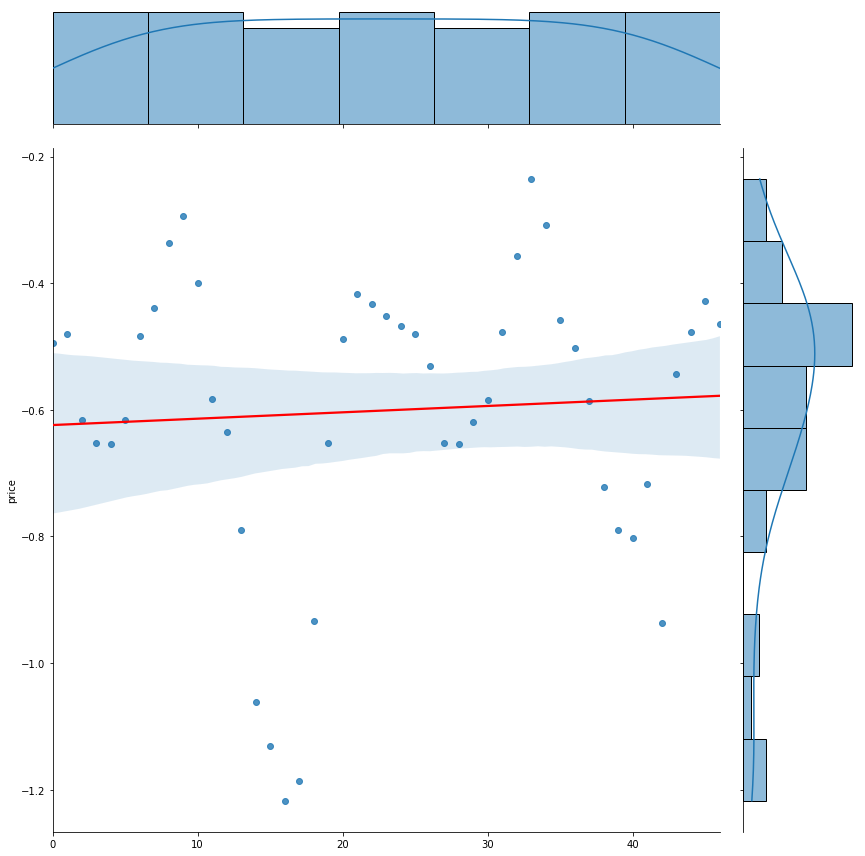

In [80]:
#plotting of the BTSS ridge linear regression model
# Plot outputs
X_train1=np.arange(0,len(Btss_std_y_train),1)

grah_lm= sns.jointplot(X_train1, Btss_std_y_train,kind='reg',height=12)
regline = grah_lm.ax_joint.get_lines()[0]
regline.set_color('red')
regline.set_zorder(5)

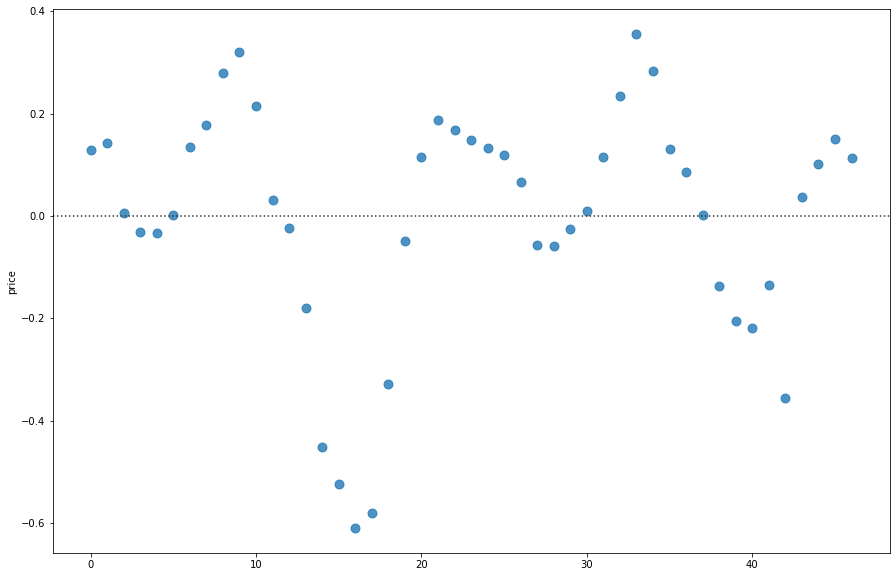

In [81]:
#plotting the residuals

f, ax = plt.subplots(figsize=(15, 10))
sns.residplot(X_train1, Btss_std_y_train,
              scatter_kws={"s": 80});

In [82]:
#results_df.loc[len(results_df)] = ['Ridge LR Standardized (BTSS)', mean_squared_error(Btss_std_y_test,ridge_reg.predict(Btss_std_X_test) , squared=False)]
#results_df

In [83]:
get_feature_importance(ridge_reg, Btss_std_X_train.columns)

Feature: 0, Score: 0.00149
Feature: 1, Score: -0.00010
Feature: 2, Score: 0.00030
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.01869
Feature: 6, Score: 0.00000
Feature: 7, Score: -0.00106
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000


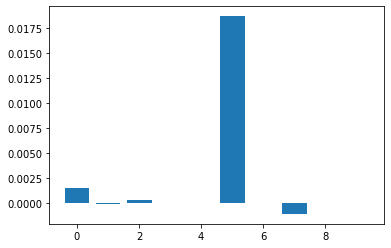

In [84]:
# Plotting the feature importance 
importance = regressor.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [85]:
Ridge_df = pd.DataFrame({'Actual': Btss_std_y_test, 'Predicted':ridge_reg_price_pred})
Ridge_df.head(5)

Actual  Predicted
31642 -0.564283  -0.389016
31643 -0.451426  -0.331441
31644 -0.464501  -0.280672
31645 -0.584928  -0.329961
31646 -0.715677  -0.452831

In [86]:
#De-standardizing the predicted output
mean = y.iloc[test_index].mean()
std = y.iloc[test_index].std()
Ridge_df_destandardized = Ridge_df.apply(lambda row:((row*std)+mean),axis =1)
Ridge_df_destandardized.head(5)

Actual  Predicted
31642  35.732810  36.555162
31643  36.262333  36.825301
31644  36.200986  37.063509
31645  35.635946  36.832246
31646  35.022474  36.255744

In [87]:
# RMSE(post de-standardising the variables):
print('Test RMSE: %.2f' % mean_squared_error(Btss_y_test, Ridge_df_destandardized.Predicted, squared=False))

Test RMSE: 4.48


In [88]:
results_df.loc[len(results_df)] = ['Ridge LR Standardized (BTSS)', mean_squared_error(Btss_y_test, Ridge_df_destandardized.Predicted , squared=False)]
results_df

Algorithm       RMSE
0                   LR Baseline  17.767744
1             LR Baseline (TSS)  10.468930
2            LR Baseline (BTSS)   4.398897
3   Ridge LR Standardized (TSS)   9.294806
4                Ridge LR (TSS)  10.466368
5  Ridge LR Standardized (BTSS)   4.484383

In [89]:
#sample cross validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(ridge_reg, Btss_X_train, Btss_y_train, cv=47, scoring='neg_root_mean_squared_error')
ridge_rmse_scores = (-scores)
display_scores(ridge_rmse_scores)

Scores: [-1.29750184 -1.07624028 -2.72954671 -0.09379598 -0.37870647 -0.37261353
 -1.06685176 -0.16073656 -0.64014666 -1.60662662 -0.91212136 -1.00720996
 -1.16823678 -1.81341611 -1.21237318 -1.91539224 -2.8018882  -3.11633261
 -1.42337023 -0.7648373  -1.6550448  -0.70721034 -0.27294407 -0.55149935
 -0.6607112  -1.16506773 -0.32117961 -2.00458727 -0.87527721 -1.36212473
 -1.14587724 -1.14835288 -1.78674743 -0.61474031 -0.80660676 -0.70278551
 -2.08332425 -3.15074703 -1.88024639 -0.62896396 -0.87108668 -1.39606891
 -4.54775057 -0.2409639  -0.27246379 -0.83686702 -0.61314131]
Mean -1.2310707368305016
Standard Deviation: 0.8946396200395008


In [90]:
from sklearn.model_selection import GridSearchCV

params_Ridge = {'alpha': [1,0.1,0.01,0.001,0.0001,0] , "fit_intercept": [True, False], "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

grid_search = GridSearchCV(ridge_reg, params_Ridge , cv = 5 , scoring = 'neg_root_mean_squared_error', return_train_score = True)

grid_search.fit(Btss_X_train, Btss_y_train)

grid_search.best_params_

{'alpha': 0.01, 'fit_intercept': True, 'solver': 'sag'}

In [91]:
grid_search.best_estimator_

Ridge(alpha=0.01, solver='sag')

In [92]:
ridge_reg = Ridge(alpha=1, fit_intercept=False, solver='sparse_cg')
ridge_reg.fit(Btss_std_X_train, Btss_std_y_train)

ridge_reg_price_pred = ridge_reg.predict(Btss_std_X_test)

# The coefficients
print('Coefficients: \n', ridge_reg.coef_)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % ridge_reg.score(Btss_std_X_train, Btss_std_y_train))
print('Test R-Squared: %.2f' % r2_score(Btss_std_y_test,ridge_reg_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Btss_std_y_test,ridge_reg_price_pred, squared=False))

Coefficients: 
 [ 0.39298259 -0.01703657  0.04295254 -0.00291961  0.013673    0.04552518
  0.05125473 -0.16054282 -0.21165658  0.0230384 ]
Train R-Squared: 0.81
Test R-Squared: 0.31
Test RMSE: 0.26


In [93]:
Ridge_df = pd.DataFrame({'Actual': Btss_std_y_test, 'Predicted':ridge_reg_price_pred})
Ridge_df.head(5)

Actual  Predicted
31642 -0.564283  -0.391116
31643 -0.451426  -0.332843
31644 -0.464501  -0.281615
31645 -0.584928  -0.331338
31646 -0.715677  -0.454932

In [94]:
#De-standardizing the predicted output
mean = y.iloc[test_index].mean()
std = y.iloc[test_index].std()
Ridge_df_destandardized = Ridge_df.apply(lambda row:((row*std)+mean),axis =1)
Ridge_df_destandardized.head(5)

Actual  Predicted
31642  35.732810  36.545305
31643  36.262333  36.818721
31644  36.200986  37.059085
31645  35.635946  36.825786
31646  35.022474  36.245885

In [95]:
# RMSE(post de-standardising the variables):
print('Test RMSE: %.2f' % mean_squared_error(Btss_y_test, Ridge_df_destandardized.Predicted, squared=False))

Test RMSE: 4.49


##### 5.2. Non-Standardized Variables

In [96]:
ridge_reg = Ridge(alpha = 1, solver = "cholesky")
ridge_reg.fit(Btss_X_train, Btss_y_train)

ridge_reg_price_pred = ridge_reg.predict(Btss_X_test)

# The coefficients
print('Coefficients: \n', ridge_reg.coef_)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % ridge_reg.score(Btss_X_train, Btss_y_train))
print('Test R-Squared: %.2f' % r2_score(Btss_y_test,ridge_reg_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Btss_y_test,ridge_reg_price_pred, squared=False))

Coefficients: 
 [ 1.48708781e-03 -9.84211042e-05  2.99014667e-04  0.00000000e+00
  0.00000000e+00  1.86659579e-02  0.00000000e+00 -1.06372677e-03
  0.00000000e+00  0.00000000e+00]
Train R-Squared: 0.83
Test R-Squared: 0.08
Test RMSE: 4.40


In [97]:
results_df.loc[len(results_df)] = ['Ridge LR (BTSS)', mean_squared_error(Btss_y_test,ridge_reg.predict(Btss_X_test) , squared=False)]
results_df

Algorithm       RMSE
0                   LR Baseline  17.767744
1             LR Baseline (TSS)  10.468930
2            LR Baseline (BTSS)   4.398897
3   Ridge LR Standardized (TSS)   9.294806
4                Ridge LR (TSS)  10.466368
5  Ridge LR Standardized (BTSS)   4.484383
6               Ridge LR (BTSS)   4.398964

In [98]:
get_feature_importance(ridge_reg, Btss_X_train.columns)

In [99]:
Ridge_df = pd.DataFrame({'Actual': Btss_y_test, 'Predicted':ridge_reg_price_pred})
Ridge_df.head(5)

Actual  Predicted
31690   40.29  42.613666
31691   41.93  43.418972
31692   41.74  44.179703
31693   39.99  43.136917
31694   38.09  40.571365

#### 6. Lasso Linear Regression (TSS)

##### 6.1. Standardized Variables (in order to allow for regression coefficient comparison)

In [100]:
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(Tss_std_X_train, Tss_std_y_train)

lasso_price_pred = lasso_reg.predict(Tss_std_X_test)

# The coefficients
print('Coefficients: \n', lasso_reg.coef_)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % lasso_reg.score(Tss_std_X_train, Tss_std_y_train))
print('Test R-Squared: %.2f' % r2_score(Tss_std_y_test,lasso_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Tss_std_y_test, lasso_price_pred, squared=False))

Coefficients: 
 [ 0.51470219 -0.         -0.         -0.         -0.          0.
  0.         -0.         -0.25457663 -0.08400314]
Train R-Squared: 0.62
Test R-Squared: 0.11
Test RMSE: 0.46


In [101]:
#results_df.loc[len(results_df)] = ['Lasso LR Standardized (TSS)', mean_squared_error(Tss_std_y_test,lasso_reg.predict(Tss_std_X_test) , squared=False)]
#results_df

In [102]:
get_feature_importance(lasso_reg, Tss_std_X_train.columns)

In [103]:
Lasso_df = pd.DataFrame({'Actual': Tss_std_y_test, 'Predicted':lasso_price_pred})
Lasso_df.head(5)

Actual  Predicted
32064 -1.215964  -1.444468
32065 -1.348777  -1.483040
32066 -1.380432  -1.496228
32067 -1.312993  -1.416255
32068 -0.970293  -1.330334

In [104]:
#De-standardizing the predicted output
mean = y.iloc[test_index].mean()
std = y.iloc[test_index].std()
Lasso_df_destandardized = Lasso_df.apply(lambda row:((row*std)+mean),axis =1)
Lasso_df_destandardized.head(5)

Actual  Predicted
32064  32.675136  31.602996
32065  32.051978  31.422021
32066  31.903453  31.360140
32067  32.219876  31.735371
32068  33.827818  32.138511

In [105]:
# RMSE(post de-standardising the variables):
print('Test RMSE: %.2f' % mean_squared_error(Tss_y_test, Lasso_df_destandardized.Predicted, squared=False))

Test RMSE: 9.70


In [106]:
results_df.loc[len(results_df)] = ['Lasso LR Standardized (TSS)', mean_squared_error(Tss_y_test, Lasso_df_destandardized.Predicted , squared=False)]
results_df

Algorithm       RMSE
0                   LR Baseline  17.767744
1             LR Baseline (TSS)  10.468930
2            LR Baseline (BTSS)   4.398897
3   Ridge LR Standardized (TSS)   9.294806
4                Ridge LR (TSS)  10.466368
5  Ridge LR Standardized (BTSS)   4.484383
6               Ridge LR (BTSS)   4.398964
7   Lasso LR Standardized (TSS)   9.696076

##### 6.2. Non - Standardized Variables

In [107]:
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(Tss_X_train, Tss_y_train)

lasso_price_pred = lasso_reg.predict(Tss_X_test)

# The coefficients
print('Coefficients: \n', lasso_reg.coef_)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % lasso_reg.score(Tss_X_train, Tss_y_train))
print('Test R-Squared: %.2f' % r2_score(Tss_y_test,lasso_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Tss_y_test, lasso_price_pred, squared=False))

Coefficients: 
 [ 1.89123679e-03  4.06809204e-05 -3.04624201e-04  2.39945248e-04
  0.00000000e+00 -5.16262999e-02  1.13010910e+00 -1.68830526e-04
 -1.22051686e+01 -5.58177477e+00]
Train R-Squared: 0.64
Test R-Squared: -1.18
Test RMSE: 10.55


In [108]:
results_df.loc[len(results_df)] = ['Lasso LR (TSS)', mean_squared_error(Tss_y_test,lasso_reg.predict(Tss_X_test) , squared=False)]
results_df

Algorithm       RMSE
0                   LR Baseline  17.767744
1             LR Baseline (TSS)  10.468930
2            LR Baseline (BTSS)   4.398897
3   Ridge LR Standardized (TSS)   9.294806
4                Ridge LR (TSS)  10.466368
5  Ridge LR Standardized (BTSS)   4.484383
6               Ridge LR (BTSS)   4.398964
7   Lasso LR Standardized (TSS)   9.696076
8                Lasso LR (TSS)  10.550067

In [109]:
get_feature_importance(lasso_reg, Tss_X_train.columns)

In [110]:
Lasso_df = pd.DataFrame({'Actual': Tss_y_test, 'Predicted':lasso_price_pred})
Lasso_df.head(5)

Actual  Predicted
32112   30.82  23.847397
32113   28.89  23.102069
32114   28.43  22.798516
32115   29.41  24.093410
32116   34.39  25.576727

#### 7. Lasso Linear Regression (BTSS)

##### 7.1. Standardized Variables (in order to allow for regression coefficient comparison)

In [111]:
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(Btss_std_X_train, Btss_std_y_train)

lasso_price_pred = lasso_reg.predict(Btss_std_X_test)

# The coefficients
print('Coefficients: \n', lasso_reg.coef_)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % lasso_reg.score(Btss_std_X_train, Btss_std_y_train))
print('Test R-Squared: %.2f' % r2_score(Btss_std_y_test,lasso_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Btss_std_y_test, lasso_price_pred, squared=False))

Coefficients: 
 [ 0.          0.          0.         -0.         -0.          0.03804357
  0.         -0.         -0.         -0.        ]
Train R-Squared: 0.18
Test R-Squared: 0.10
Test RMSE: 0.30


In [112]:
#results_df.loc[len(results_df)] = ['Lasso LR Standardized (BTSS)', mean_squared_error(Btss_std_y_test,lasso_reg.predict(Btss_std_X_test) , squared=False)]
#results_df

In [113]:
get_feature_importance(lasso_reg, Btss_std_X_train.columns)

In [114]:
Lasso_df = pd.DataFrame({'Actual': Btss_std_y_test, 'Predicted':lasso_price_pred})
Lasso_df.head(5)

Actual  Predicted
31642 -0.564283  -0.603679
31643 -0.451426  -0.598183
31644 -0.464501  -0.592687
31645 -0.584928  -0.587191
31646 -0.715677  -0.581695

In [115]:
#De-standardizing the predicted output
mean = y.iloc[test_index].mean()
std = y.iloc[test_index].std()
Lasso_df_destandardized = Lasso_df.apply(lambda row:((row*std)+mean),axis =1)
Lasso_df_destandardized.head(5)

Actual  Predicted
31642  35.732810  35.547966
31643  36.262333  35.573753
31644  36.200986  35.599540
31645  35.635946  35.625327
31646  35.022474  35.651114

In [116]:
# RMSE(post de-standardising the variables):
print('Test RMSE: %.2f' % mean_squared_error(Btss_y_test, Lasso_df_destandardized.Predicted, squared=False))

Test RMSE: 5.26


In [117]:
results_df.loc[len(results_df)] = ['Lasso LR Standardized (BTSS)', mean_squared_error(Btss_y_test, Lasso_df_destandardized.Predicted , squared=False)]
results_df

Algorithm       RMSE
0                   LR Baseline  17.767744
1             LR Baseline (TSS)  10.468930
2            LR Baseline (BTSS)   4.398897
3   Ridge LR Standardized (TSS)   9.294806
4                Ridge LR (TSS)  10.466368
5  Ridge LR Standardized (BTSS)   4.484383
6               Ridge LR (BTSS)   4.398964
7   Lasso LR Standardized (TSS)   9.696076
8                Lasso LR (TSS)  10.550067
9  Lasso LR Standardized (BTSS)   5.259953

##### 7.2. Non - Standardized Variables

In [118]:
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(Btss_X_train, Btss_y_train)

lasso_price_pred = lasso_reg.predict(Btss_X_test)

# The coefficients
print('Coefficients: \n', lasso_reg.coef_)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % lasso_reg.score(Btss_X_train, Btss_y_train))
print('Test R-Squared: %.2f' % r2_score(Btss_y_test,lasso_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Btss_y_test, lasso_price_pred, squared=False))

Coefficients: 
 [ 1.49885501e-03 -8.92314367e-05  3.00681607e-04  0.00000000e+00
  0.00000000e+00  1.28584487e-02  0.00000000e+00 -1.07162657e-03
  0.00000000e+00  0.00000000e+00]
Train R-Squared: 0.83
Test R-Squared: 0.08
Test RMSE: 4.42


In [119]:
results_df.loc[len(results_df)] = ['Lasso LR (BTSS)', mean_squared_error(Btss_y_test,lasso_reg.predict(Btss_X_test) , squared=False)]
results_df

Algorithm       RMSE
0                    LR Baseline  17.767744
1              LR Baseline (TSS)  10.468930
2             LR Baseline (BTSS)   4.398897
3    Ridge LR Standardized (TSS)   9.294806
4                 Ridge LR (TSS)  10.466368
5   Ridge LR Standardized (BTSS)   4.484383
6                Ridge LR (BTSS)   4.398964
7    Lasso LR Standardized (TSS)   9.696076
8                 Lasso LR (TSS)  10.550067
9   Lasso LR Standardized (BTSS)   5.259953
10               Lasso LR (BTSS)   4.415596

In [120]:
get_feature_importance(lasso_reg, Btss_X_train.columns)

In [121]:
Lasso_df = pd.DataFrame({'Actual': Btss_y_test, 'Predicted':lasso_price_pred})
Lasso_df.head(5)

Actual  Predicted
31690   40.29  42.600894
31691   41.93  43.407575
31692   41.74  44.169016
31693   39.99  43.113808
31694   38.09  40.524630

#### 8. ARIMA MODEL

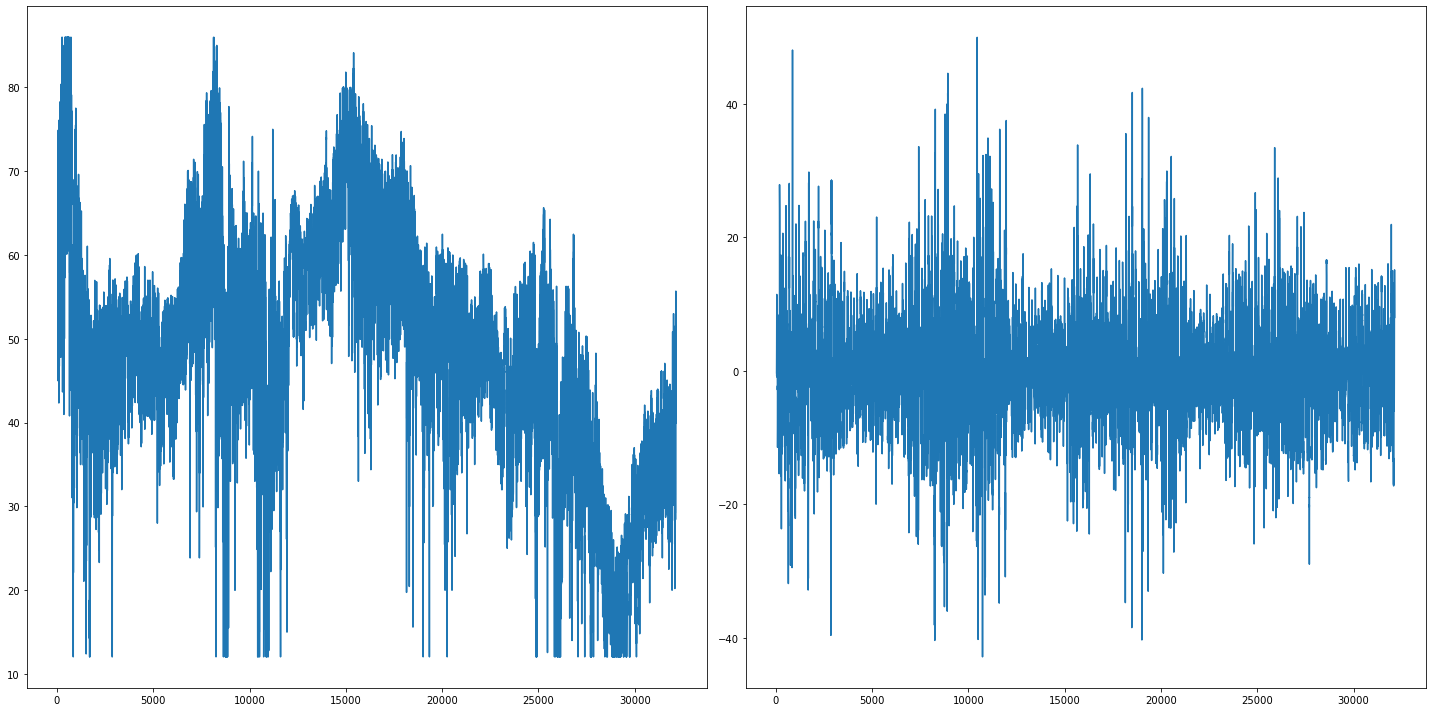

In [122]:
# Checking for stationarity in the price and lag

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].plot(pm_df['price'])
axes[1].plot(pm_df['price_lag_daily'])
fig.tight_layout()

In [123]:
#pm_df = pm_df.iloc[24:]
from statsmodels.tsa.stattools import adfuller
series = pm_df.loc[:, 'price_lag_daily'].values

result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

# Based on this test, it is indeed stationary

ADF Statistic: -28.604032
p-value: 0.000000
Critical Values:


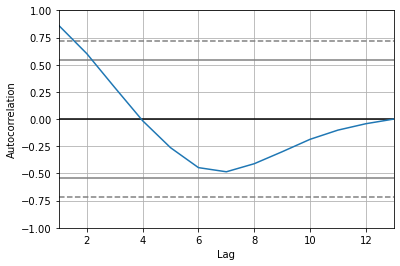

In [124]:
#Sampling
from matplotlib import pyplot
sample_arima = pm_df.iloc[0:13]
series_arima = sample_arima.loc[:, 'price'].values

# Autocorrelation plot
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series_arima)
pyplot.show()

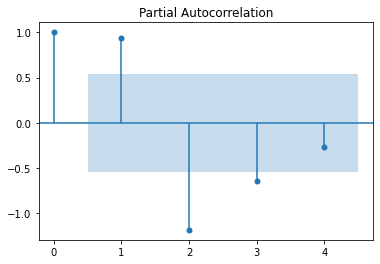

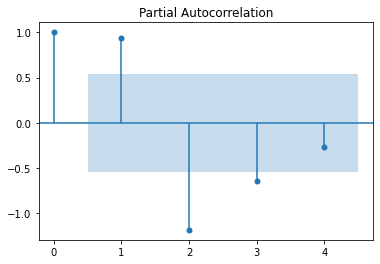

In [125]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(series_arima, lags = 4)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   13
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -33.386
Date:                Wed, 31 Mar 2021   AIC                             70.771
Time:                        03:45:51   BIC                             71.741
Sample:                             0   HQIC                            70.412
                                 - 13                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5839      0.137      4.258      0.000       0.315       0.853
sigma2        14.7561      6.480      2.277      0.023       2.056      27.456
Ljung-Box (L1) (Q):                   0.33   Jarque-

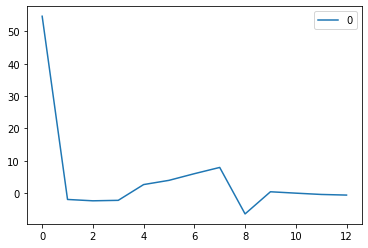

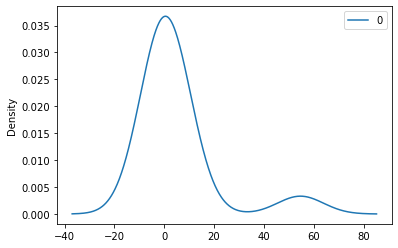

               0
count  13.000000
mean    4.756283
std    15.476249
min    -6.408647
25%    -1.940715
50%     0.009414
75%     3.964902
max    54.680000


In [126]:
# Importing ARIMA functions 
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot

# ARIMA 2
# fit model
model = ARIMA(series_arima, order=(1,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

#### Running & Cross Validating ARIMA (Long computation and not essential for this exercise. Mean RMSE +- 2.0)

In [127]:
# split into train and test sets
#w = pm_df.values
#w = pm_df.loc[:, 'price'].values
#size = int(len(w) * 0.66)
#train, test = w[0:size], w[size:len(w)]
#history = [w for w in train]
#arima_predictions = list()
# walk-forward validation
#for t in range(len(test)):
    #model = ARIMA(history, order=(1,1,0)) # adjust to include real one
    #model_fit = model.fit()
    #output = model_fit.forecast()
    #yhat = output[0]
    #arima_predictions.append(yhat)
    #obs = test[t]
    #history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
 #evaluate forecasts
#rmse = sqrt(mean_squared_error(test, arima_predictions))
#print('Test RMSE: %.3f' % rmse)
#plot forecasts against actual outcomes
#pyplot.plot(test)
#pyplot.plot(arima_predictions, color='red')
#pyplot.show()

In [128]:
#results_df.loc[len(results_df)] = ['ARIMA(1,1,0)', mean_squared_error(test, arima_predictions, squared=False)]
#results_df

#### 9. Random Forest

###### 9.1 Random Forest (TSS)

In [129]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(Tss_X_train, Tss_y_train)

forest_price_pred = forest_reg.predict(Tss_X_test)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % forest_reg.score(Tss_X_train, Tss_y_train))
print('Test R-Squared: %.2f' % r2_score(Tss_y_test,forest_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Tss_y_test, forest_price_pred, squared=False))

Train R-Squared: 0.97
Test R-Squared: -0.32
Test RMSE: 8.21


In [130]:
results_df.loc[len(results_df)] = ['Random Forest(TSS)', mean_squared_error(Tss_y_test,forest_reg.predict(Tss_X_test) , squared=False)]
results_df

Algorithm       RMSE
0                    LR Baseline  17.767744
1              LR Baseline (TSS)  10.468930
2             LR Baseline (BTSS)   4.398897
3    Ridge LR Standardized (TSS)   9.294806
4                 Ridge LR (TSS)  10.466368
5   Ridge LR Standardized (BTSS)   4.484383
6                Ridge LR (BTSS)   4.398964
7    Lasso LR Standardized (TSS)   9.696076
8                 Lasso LR (TSS)  10.550067
9   Lasso LR Standardized (BTSS)   5.259953
10               Lasso LR (BTSS)   4.415596
11            Random Forest(TSS)   8.211579

In [131]:
forest_df = pd.DataFrame({'Actual': Tss_y_test, 'Predicted':forest_price_pred})
forest_df.head(5)

Actual  Predicted
32112   30.82    29.5762
32113   28.89    29.1113
32114   28.43    28.9801
32115   29.41    28.2486
32116   34.39    29.2328

###### 9.2 Random Forest (BTSS)

In [132]:
forest_reg = RandomForestRegressor()
forest_reg.fit(Btss_X_train, Btss_y_train)

forest_price_pred = forest_reg.predict(Btss_X_test)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % forest_reg.score(Btss_X_train, Btss_y_train))
print('Test R-Squared: %.2f' % r2_score(Btss_y_test,forest_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Btss_y_test, forest_price_pred, squared=False))

Train R-Squared: 0.98
Test R-Squared: 0.13
Test RMSE: 4.30


In [133]:
results_df.loc[len(results_df)] = ['Random Forest(BTSS)', mean_squared_error(Btss_y_test,forest_reg.predict(Btss_X_test) , squared=False)]
results_df

Algorithm       RMSE
0                    LR Baseline  17.767744
1              LR Baseline (TSS)  10.468930
2             LR Baseline (BTSS)   4.398897
3    Ridge LR Standardized (TSS)   9.294806
4                 Ridge LR (TSS)  10.466368
5   Ridge LR Standardized (BTSS)   4.484383
6                Ridge LR (BTSS)   4.398964
7    Lasso LR Standardized (TSS)   9.696076
8                 Lasso LR (TSS)  10.550067
9   Lasso LR Standardized (BTSS)   5.259953
10               Lasso LR (BTSS)   4.415596
11            Random Forest(TSS)   8.211579
12           Random Forest(BTSS)   4.295087

In [134]:
forest_df = pd.DataFrame({'Actual': Btss_y_test, 'Predicted': forest_price_pred})
forest_df.head(5)

Actual  Predicted
31690   40.29    41.5146
31691   41.93    42.5979
31692   41.74    42.7264
31693   39.99    42.5400
31694   38.09    41.4077

#### Cross Validation & Model Fine Tuning

In [135]:
scores = cross_val_score(forest_reg, Btss_X_train, Btss_y_train, cv=47, scoring='neg_root_mean_squared_error') 
forest_rmse_scores = (-scores)
display_scores(forest_rmse_scores)

Scores: [-0.5168 -0.5874 -0.9456 -0.2753 -0.7825 -0.357  -1.5868 -0.6382 -1.1516
 -0.9692 -0.7579 -1.4341 -1.1924 -2.2931 -3.223  -1.3294 -1.8905 -2.8649
 -2.0512 -2.0427 -0.0215 -0.7814 -1.0597 -0.5828 -0.3096 -0.0934 -0.6145
 -0.3725 -0.3816 -0.0509 -0.2319 -1.4734 -0.6744 -1.5318 -0.4186 -1.084
 -1.1275 -0.1944 -0.957  -1.0416 -0.7339 -3.5929 -1.313  -0.2118 -0.2801
 -0.4908 -0.2148]
Mean -0.9942425531914908
Standard Deviation: 0.8093972216684076


In [136]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [12,24,365] , 'max_features': [2,3,4,6] },
             {'bootstrap': [False], 'n_estimators': [12,24,365] , 'max_features': [2,3,4]}]

grid_search = GridSearchCV(forest_reg, param_grid , cv = 5 , scoring = 'neg_root_mean_squared_error', return_train_score = True)

grid_search.fit(Btss_X_train, Btss_y_train)

grid_search.best_params_

{'max_features': 6, 'n_estimators': 12}

In [137]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=12)

In [138]:
forest_reg = RandomForestRegressor(max_features=6, n_estimators=365)
forest_reg.fit(Btss_X_train, Btss_y_train)

forest_price_pred = forest_reg.predict(Btss_X_test)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % forest_reg.score(Btss_X_train, Btss_y_train))
print('Test R-Squared: %.2f' % r2_score(Btss_y_test,forest_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Btss_y_test, forest_price_pred, squared=False))

Train R-Squared: 0.98
Test R-Squared: 0.21
Test RMSE: 4.10


Text(0, 0.5, 'FEATURE NAMES')

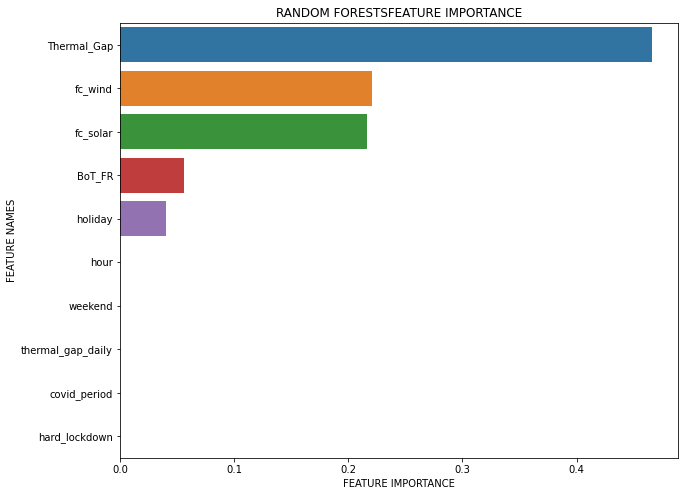

In [139]:
#s Radom Forest BTSS variable importance

feature_importances = pd.DataFrame(forest_reg.feature_importances_, index = Btss_X_train.columns,columns=['importance']).sort_values('importance', ascending=False)
feature_importances

plt.figure(figsize=(10,8))
#Plot Searborn bar chart
sns.barplot(x=list(feature_importances['importance']), y=Btss_X_train.columns)
#Add chart labels
plt.title('RANDOM FORESTS' + 'FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES') 

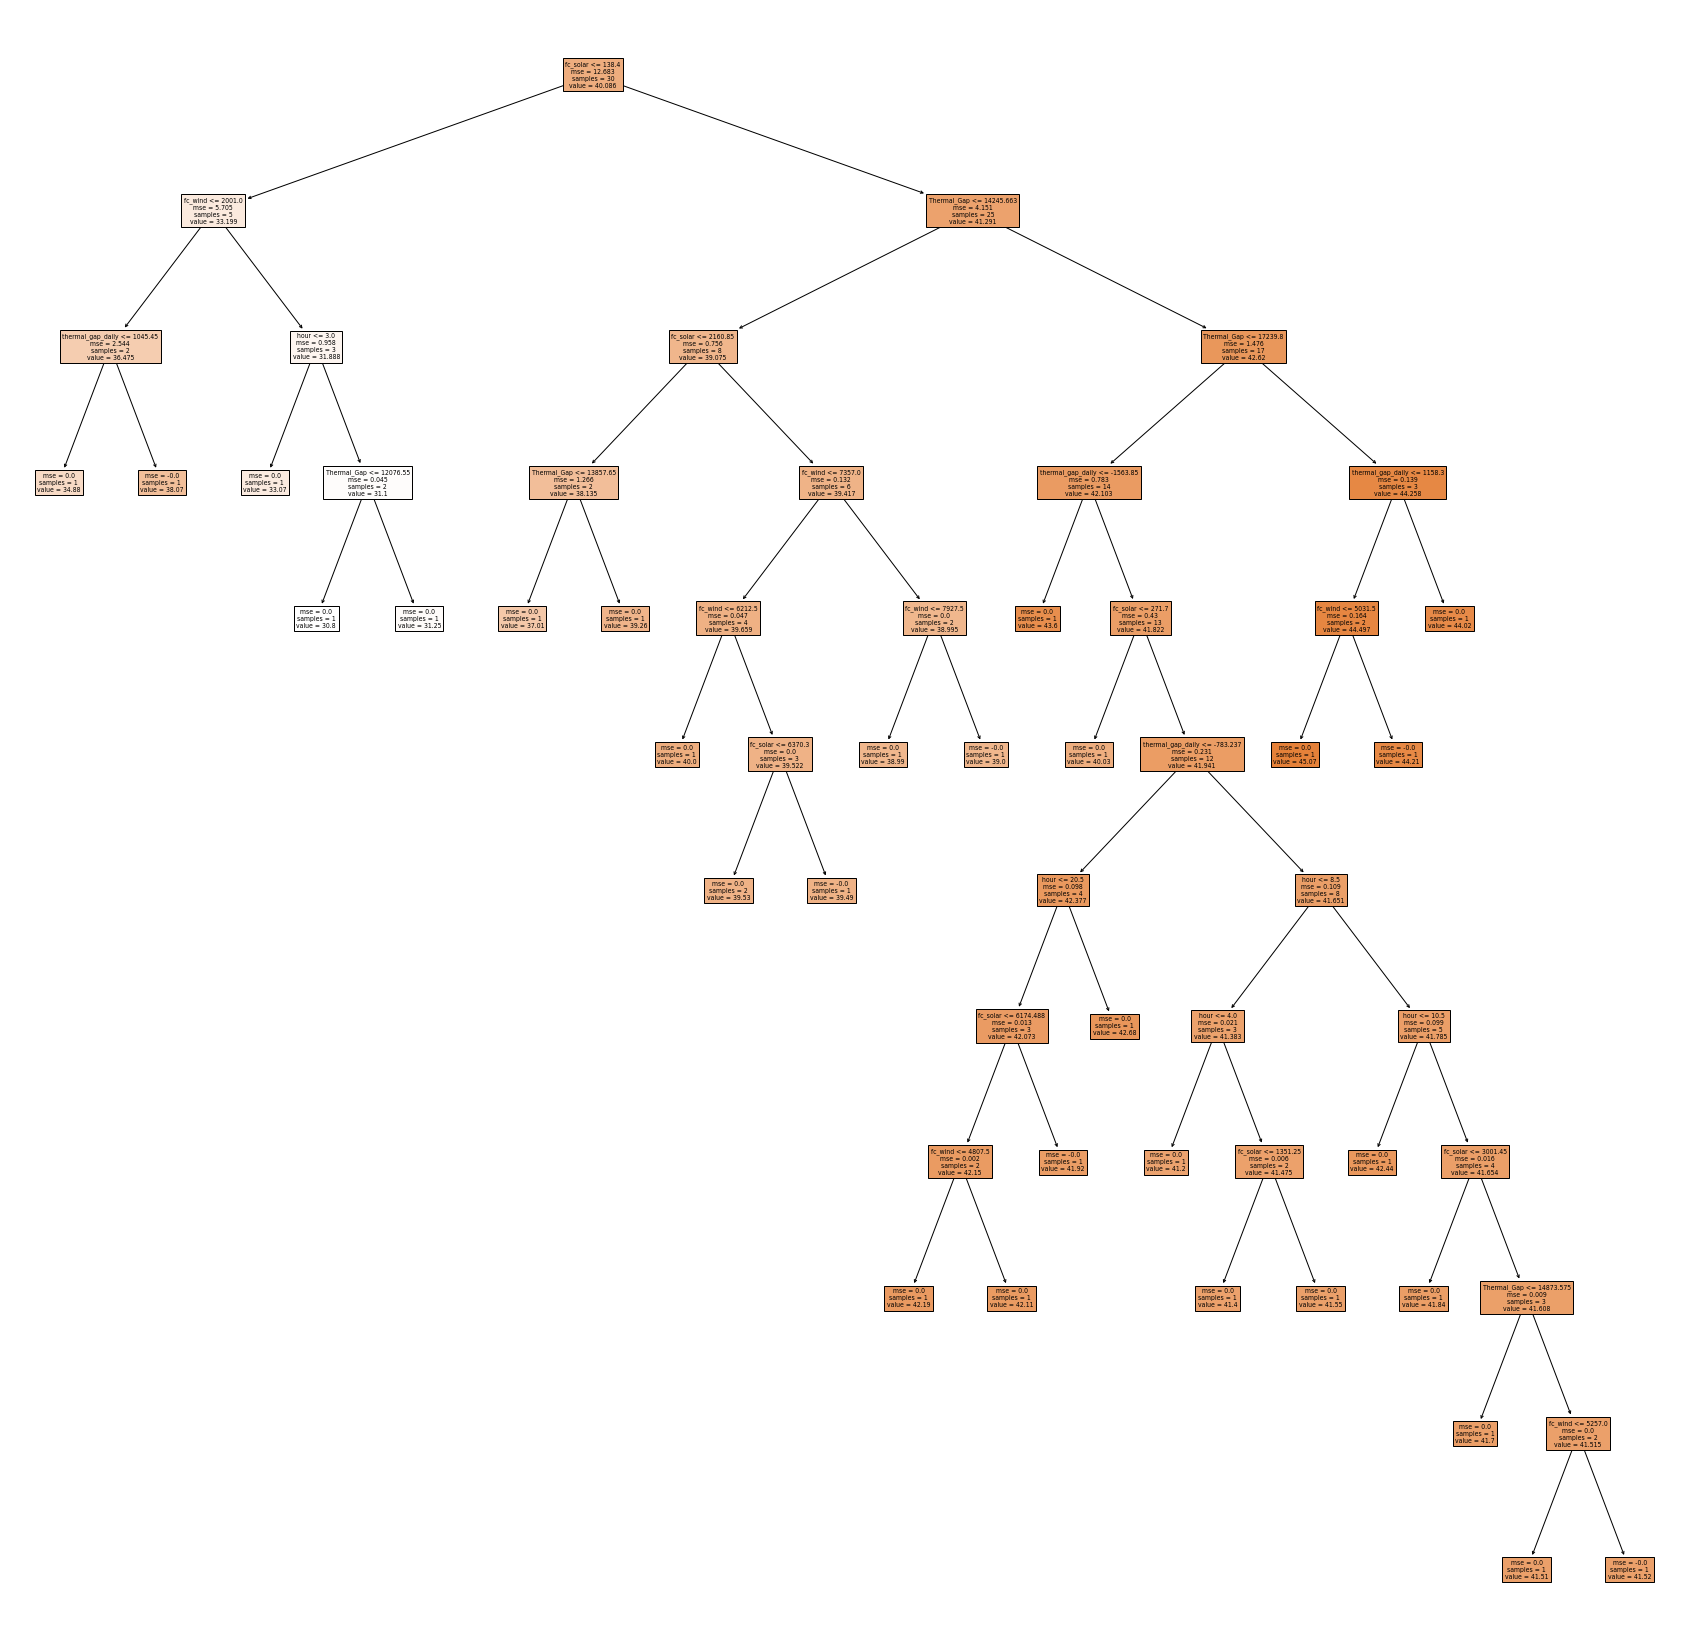

In [140]:
#Visualizing one tree of the random forest BTSS model
plt.figure(figsize=(30,30))
_ = tree.plot_tree(forest_reg.estimators_[0], feature_names=Btss_X_train.columns, filled=True)

##### Temptative Optimal Fine Tuning (cv = btss : extremely heavy computation)

In [141]:
#from sklearn.model_selection import GridSearchCV

#param_grid = [{'n_estimators': [12,24,365] , 'max_features': [2,3,4,6] },
             #{'bootstrap': [False], 'n_estimators': [12,24,365] , 'max_features': [2,3,4]}]

#grid_search = GridSearchCV(forest_reg, param_grid , cv = btss , scoring = 'neg_mean_squared_error', return_train_score = True)

#grid_search.fit(Btss_X_train, Btss_y_train)

#grid_search.best_params_

#### 10. Support Vector Regressor (SVR)

**Note**: Requires data to be standardized.

##### 10.1. SVR (TSS)

In [142]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon = 1.5)
svm_reg.fit(Tss_std_X_train, Tss_std_y_train)

svm_price_pred = svm_reg.predict(Tss_std_X_test)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % svm_reg.score(Tss_std_X_train, Tss_std_y_train))
print('Test R-Squared: %.2f' % r2_score(Tss_std_y_test,svm_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Tss_std_y_test, svm_price_pred, squared=False))

Train R-Squared: 0.60
Test R-Squared: 0.71
Test RMSE: 0.26


In [143]:
#results_df.loc[len(results_df)] = ['SVR Standardized', mean_squared_error(Tss_std_y_test,svm_reg.predict(Tss_std_X_test) , squared=False)]
#results_df

In [144]:
svm_df = pd.DataFrame({'Actual': Tss_std_y_test, 'Predicted': svm_price_pred})
svm_df.head(5)

Actual  Predicted
32064 -1.215964  -1.411400
32065 -1.348777  -1.472814
32066 -1.380432  -1.495046
32067 -1.312993  -1.402626
32068 -0.970293  -1.293604

In [145]:
#De-standardizing the predicted output
mean = y.iloc[test_index].mean()
std = y.iloc[test_index].std()
svr_df_destandardized = svm_df.apply(lambda row:((row*std)+mean),axis =1)
svr_df_destandardized.head(5)

Actual  Predicted
32064  32.675136  31.758154
32065  32.051978  31.470001
32066  31.903453  31.365689
32067  32.219876  31.799318
32068  33.827818  32.310847

In [146]:
# RMSE(post de-standardising the variables):
#print('Test RMSE: %.2f' % mean_squared_error(Tss_y_test, svr_df_destandardized.Predicted, squared=False))

In [147]:
#results_df.loc[len(results_df)] = ['SVR Standardized', mean_squared_error(Tss_y_test, svr_df_destandardized.Predicted, squared=False)]
#results_df

#### Cross Validation & Model Fine Tuning

In [148]:
scores = cross_val_score(svm_reg, Tss_std_X_train, Tss_std_y_train, cv=47, scoring='neg_root_mean_squared_error')
svm_rmse_scores =(-scores)
display_scores(svm_rmse_scores)

Scores: [-1.23321542 -0.42645488 -0.52743087 -0.30799735 -0.42344421 -0.62773267
 -0.69443483 -0.65086723 -0.52432152 -0.40201459 -0.42028138 -0.57037387
 -0.63418371 -0.39894882 -0.31107176 -0.7599727  -0.66905461 -0.36134085
 -0.26678043 -0.35127632 -0.64828022 -0.92592038 -1.30295907 -0.86740712
 -0.56674768 -0.66885121 -0.58711961 -0.36310809 -0.30662731 -0.44889917
 -0.26306268 -0.48484779 -0.5350697  -0.6809525  -0.69153978 -0.49907671
 -0.49481398 -0.75608808 -1.33783268 -0.98248989 -0.99169851 -0.29120639
 -0.90492997 -0.42522231 -0.48245251 -0.68579237 -0.55141695]
Mean -0.602247036333474
Standard Deviation: 0.2589481176168847


In [149]:
param_grid = [{'epsilon': [0,1.0,2.0] , 'C': [0.75,1,1.25]}]

grid_search = GridSearchCV(svm_reg, param_grid , cv = 10 , scoring = 'neg_root_mean_squared_error', return_train_score = True)

grid_search.fit(Tss_X_train, Tss_y_train)

grid_search.best_params_

{'C': 0.75, 'epsilon': 2.0}

In [150]:
grid_search.best_estimator_

LinearSVR(C=0.75, epsilon=2.0)

In [151]:
svm_reg = LinearSVR(C=0.75, epsilon=0)
svm_reg.fit(Tss_std_X_train, Tss_std_y_train)

svm_price_pred = svm_reg.predict(Tss_std_X_test)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % svm_reg.score(Tss_std_X_train, Tss_std_y_train))
print('Test R-Squared: %.2f' % r2_score(Tss_std_y_test,svm_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Tss_std_y_test, svm_price_pred, squared=False))

Train R-Squared: 0.64
Test R-Squared: -0.84
Test RMSE: 0.67


In [152]:
#De-standardizing the predicted output
mean = y.iloc[test_index].mean()
std = y.iloc[test_index].std()
svr_df_destandardized = svm_df.apply(lambda row:((row*std)+mean),axis =1)
svr_df_destandardized.head(5)

Actual  Predicted
32064  32.675136  31.758154
32065  32.051978  31.470001
32066  31.903453  31.365689
32067  32.219876  31.799318
32068  33.827818  32.310847

In [153]:
# RMSE(post de-standardising the variables):
print('Test RMSE: %.2f' % mean_squared_error(Tss_y_test, svr_df_destandardized.Predicted, squared=False))

Test RMSE: 8.59


In [154]:
results_df.loc[len(results_df)] = ['SVR Standardized', mean_squared_error(Tss_y_test, svr_df_destandardized.Predicted, squared=False)]
results_df

Algorithm       RMSE
0                    LR Baseline  17.767744
1              LR Baseline (TSS)  10.468930
2             LR Baseline (BTSS)   4.398897
3    Ridge LR Standardized (TSS)   9.294806
4                 Ridge LR (TSS)  10.466368
5   Ridge LR Standardized (BTSS)   4.484383
6                Ridge LR (BTSS)   4.398964
7    Lasso LR Standardized (TSS)   9.696076
8                 Lasso LR (TSS)  10.550067
9   Lasso LR Standardized (BTSS)   5.259953
10               Lasso LR (BTSS)   4.415596
11            Random Forest(TSS)   8.211579
12           Random Forest(BTSS)   4.295087
13              SVR Standardized   8.591501

##### 10.2. SVR (BTSS)

In [155]:
svm_reg = LinearSVR(epsilon = 1.5)
svm_reg.fit(Btss_std_X_train, Btss_std_y_train)

svm_price_pred = svm_reg.predict(Btss_std_X_test)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % svm_reg.score(Btss_std_X_train, Btss_std_y_train))
print('Test R-Squared: %.2f' % r2_score(Btss_std_y_test,svm_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Btss_std_y_test, svm_price_pred, squared=False))

Train R-Squared: -7.09
Test R-Squared: -4.84
Test RMSE: 0.76


In [156]:
#results_df.loc[len(results_df)] = ['SVR Standardized (BTSS)', mean_squared_error(Btss_std_y_test,svm_reg.predict(Btss_std_X_test) , squared=False)]
#results_df

In [157]:
svm_df = pd.DataFrame({'Actual': Btss_std_y_test, 'Predicted': svm_price_pred})
svm_df.head(5)

Actual  Predicted
31642 -0.564283        0.0
31643 -0.451426        0.0
31644 -0.464501        0.0
31645 -0.584928        0.0
31646 -0.715677        0.0

In [158]:
# RMSE(post de-standardising the variables):
print('Test RMSE: %.2f' % mean_squared_error(Btss_y_test, svm_price_pred, squared=False))

Test RMSE: 38.65


In [159]:
results_df.loc[len(results_df)] = ['SVR (BTSS)', mean_squared_error(Btss_y_test, svm_price_pred, squared=False)]
results_df

Algorithm       RMSE
0                    LR Baseline  17.767744
1              LR Baseline (TSS)  10.468930
2             LR Baseline (BTSS)   4.398897
3    Ridge LR Standardized (TSS)   9.294806
4                 Ridge LR (TSS)  10.466368
5   Ridge LR Standardized (BTSS)   4.484383
6                Ridge LR (BTSS)   4.398964
7    Lasso LR Standardized (TSS)   9.696076
8                 Lasso LR (TSS)  10.550067
9   Lasso LR Standardized (BTSS)   5.259953
10               Lasso LR (BTSS)   4.415596
11            Random Forest(TSS)   8.211579
12           Random Forest(BTSS)   4.295087
13              SVR Standardized   8.591501
14                    SVR (BTSS)  38.654286

#### 11. Decision Tree

##### 11.1. Decision Tree (TSS)

In [160]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(criterion='mse') #max_depth can be used to control size of the tree.
tree_reg.fit(Tss_X_train, Tss_y_train)

tree_price_pred = tree_reg.predict(Tss_X_test)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % tree_reg.score(Tss_X_train, Tss_y_train))
print('Test R-Squared: %.2f' % r2_score(Tss_y_test,tree_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Tss_y_test, tree_price_pred, squared=False))

Train R-Squared: 1.00
Test R-Squared: -0.61
Test RMSE: 9.08


In [161]:
results_df.loc[len(results_df)] = [' Decision Tree (TSS)', mean_squared_error(Tss_y_test,tree_reg.predict(Tss_X_test) , squared=False)]
results_df

Algorithm       RMSE
0                    LR Baseline  17.767744
1              LR Baseline (TSS)  10.468930
2             LR Baseline (BTSS)   4.398897
3    Ridge LR Standardized (TSS)   9.294806
4                 Ridge LR (TSS)  10.466368
5   Ridge LR Standardized (BTSS)   4.484383
6                Ridge LR (BTSS)   4.398964
7    Lasso LR Standardized (TSS)   9.696076
8                 Lasso LR (TSS)  10.550067
9   Lasso LR Standardized (BTSS)   5.259953
10               Lasso LR (BTSS)   4.415596
11            Random Forest(TSS)   8.211579
12           Random Forest(BTSS)   4.295087
13              SVR Standardized   8.591501
14                    SVR (BTSS)  38.654286
15           Decision Tree (TSS)   9.080890

In [162]:
tree_df = pd.DataFrame({'Actual': Tss_y_test, 'Predicted': tree_price_pred})
tree_df.head(5)

Actual  Predicted
32112   30.82      25.50
32113   28.89      25.50
32114   28.43      25.50
32115   29.41      25.50
32116   34.39      27.44

##### 11.2. Decision Tree (BTSS)

In [163]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(criterion='mse')
tree_reg.fit(Btss_X_train, Btss_y_train)

tree_price_pred = tree_reg.predict(Btss_X_test)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % tree_reg.score(Btss_X_train, Btss_y_train))
print('Test R-Squared: %.2f' % r2_score(Btss_y_test,tree_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Btss_y_test, tree_price_pred, squared=False))

Train R-Squared: 1.00
Test R-Squared: -0.07
Test RMSE: 4.74


In [164]:
results_df.loc[len(results_df)] = [' Decision Tree (BTSS)', mean_squared_error(Btss_y_test,tree_reg.predict(Btss_X_test) , squared=False)]
results_df

Algorithm       RMSE
0                    LR Baseline  17.767744
1              LR Baseline (TSS)  10.468930
2             LR Baseline (BTSS)   4.398897
3    Ridge LR Standardized (TSS)   9.294806
4                 Ridge LR (TSS)  10.466368
5   Ridge LR Standardized (BTSS)   4.484383
6                Ridge LR (BTSS)   4.398964
7    Lasso LR Standardized (TSS)   9.696076
8                 Lasso LR (TSS)  10.550067
9   Lasso LR Standardized (BTSS)   5.259953
10               Lasso LR (BTSS)   4.415596
11            Random Forest(TSS)   8.211579
12           Random Forest(BTSS)   4.295087
13              SVR Standardized   8.591501
14                    SVR (BTSS)  38.654286
15           Decision Tree (TSS)   9.080890
16          Decision Tree (BTSS)   4.743625

In [165]:
tree_df = pd.DataFrame({'Actual': Btss_y_test, 'Predicted': tree_price_pred})
tree_df.head(5)

Actual  Predicted
31690   40.29      39.98
31691   41.93      45.07
31692   41.74      45.07
31693   39.99      45.07
31694   38.09      39.98

#### Cross Validation & Model Fine Tuning

In [166]:
scores = cross_val_score(tree_reg, Btss_X_train, Btss_y_train, cv=47, scoring='neg_root_mean_squared_error')
tree_rmse_scores = (-scores)
display_scores(tree_rmse_scores)

Scores: [-0.4  -0.92 -0.53 -0.01 -0.01 -0.54 -1.46 -0.65 -1.49 -0.86 -2.65 -3.27
 -2.25 -3.94 -3.94 -2.83 -2.27 -3.68 -3.68 -2.18 -0.2  -1.14 -0.27 -1.15
 -0.19 -0.01 -0.74 -0.01 -0.5  -0.5  -1.46 -0.1  -0.86 -1.05 -1.05 -0.84
 -2.2  -1.42 -0.99 -0.99 -0.19 -3.14 -0.05 -1.84 -0.29 -0.86 -0.19]
Mean -1.272127659574468
Standard Deviation: 1.1524939399299994


In [167]:
param_grid = [{'max_depth': [1,2,4,12,24] , 'max_features': [2,3,4,6] },]

grid_search = GridSearchCV(tree_reg, param_grid , cv = 10 , scoring = 'neg_root_mean_squared_error', return_train_score = True)

grid_search.fit(Btss_X_train, Btss_y_train)

grid_search.best_params_

{'max_depth': 12, 'max_features': 3}

In [168]:
grid_search.best_estimator_

DecisionTreeRegressor(max_depth=12, max_features=3)

In [169]:
tree_reg = DecisionTreeRegressor(max_depth=24, max_features=4, criterion='mse')
tree_reg.fit(Btss_X_train, Btss_y_train)

tree_price_pred = tree_reg.predict(Btss_X_test)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % tree_reg.score(Btss_X_train, Btss_y_train))
print('Test R-Squared: %.2f' % r2_score(Btss_y_test,tree_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Btss_y_test, tree_price_pred, squared=False))

Train R-Squared: 1.00
Test R-Squared: 0.57
Test RMSE: 3.00


In [170]:
#results_df.loc[len(results_df)] = [' Decision Tree (BTSS)', mean_squared_error(Btss_y_test,tree_reg.predict(Btss_X_test) , squared=False)]
#results_df

#### 12. Gradient Boosted Trees

##### 12.1. Gradient Boosted Trees (TSS)

In [171]:
from sklearn.ensemble import GradientBoostingRegressor

boosted_tree_reg = GradientBoostingRegressor()
boosted_tree_reg.fit(Tss_X_train, Tss_y_train)

boosted_tree_price_pred = boosted_tree_reg.predict(Tss_X_test)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % boosted_tree_reg.score(Tss_X_train, Tss_y_train))
print('Test R-Squared: %.2f' % r2_score(Tss_y_test,boosted_tree_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Tss_y_test, boosted_tree_price_pred, squared=False))

Train R-Squared: 0.72
Test R-Squared: -1.04
Test RMSE: 10.20


In [172]:
results_df.loc[len(results_df)] = [' Gradient Boosted Tree (TSS)', mean_squared_error(Tss_y_test,boosted_tree_reg.predict(Tss_X_test) , squared=False)]
results_df

Algorithm       RMSE
0                    LR Baseline  17.767744
1              LR Baseline (TSS)  10.468930
2             LR Baseline (BTSS)   4.398897
3    Ridge LR Standardized (TSS)   9.294806
4                 Ridge LR (TSS)  10.466368
5   Ridge LR Standardized (BTSS)   4.484383
6                Ridge LR (BTSS)   4.398964
7    Lasso LR Standardized (TSS)   9.696076
8                 Lasso LR (TSS)  10.550067
9   Lasso LR Standardized (BTSS)   5.259953
10               Lasso LR (BTSS)   4.415596
11            Random Forest(TSS)   8.211579
12           Random Forest(BTSS)   4.295087
13              SVR Standardized   8.591501
14                    SVR (BTSS)  38.654286
15           Decision Tree (TSS)   9.080890
16          Decision Tree (BTSS)   4.743625
17   Gradient Boosted Tree (TSS)  10.203069

In [173]:
boosted_tree_df = pd.DataFrame({'Actual': Tss_y_test, 'Predicted': boosted_tree_price_pred})
boosted_tree_df.head(5)

Actual  Predicted
32112   30.82  28.173279
32113   28.89  27.339215
32114   28.43  27.526148
32115   29.41  27.366025
32116   34.39  29.015168

##### 12.2. Gradient Boosted Trees (BTSS)

In [174]:
boosted_tree_reg = GradientBoostingRegressor() 
boosted_tree_reg.fit(Btss_X_train, Btss_y_train)

boosted_tree_price_pred = boosted_tree_reg.predict(Btss_X_test)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % boosted_tree_reg.score(Btss_X_train, Btss_y_train))
print('Test R-Squared: %.2f' % r2_score(Btss_y_test,boosted_tree_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Btss_y_test, boosted_tree_price_pred, squared=False))

Train R-Squared: 1.00
Test R-Squared: 0.06
Test RMSE: 4.46


In [175]:
#results_df.loc[len(results_df)] = [' Gradient Boosted Trees (BTSS)', mean_squared_error(Btss_y_test,boosted_tree_reg.predict(Btss_X_test) , squared=False)]
#results_df

In [176]:
boosted_tree_df = pd.DataFrame({'Actual': Btss_y_test, 'Predicted': boosted_tree_price_pred})
boosted_tree_df

Actual  Predicted
31690   40.29  41.749988
31691   41.93  42.534082
31692   41.74  42.831699
31693   39.99  42.175186
31694   38.09  41.356877
31695   39.00  41.356877
31696   41.92  41.271297
31697   42.44  41.478411
31698   42.79  42.167440
31699   43.97  43.812386
31700   44.29  43.801589
31701   42.44  43.603109
31702   41.47  42.229440
31703   33.41  41.560017
31704   32.24  39.581689
31705   31.07  39.065647
31706   30.18  38.981453
31707   30.07  39.051601
31708   32.10  38.436468
31709   34.01  39.274714
31710   35.74  41.117826
31711   39.53  42.216625
31712   41.00  42.333534
31713   41.42  41.801935

#### Cross Validation & Model Fine Tuning

In [177]:
scores = cross_val_score(boosted_tree_reg, Btss_X_train, Btss_y_train, cv=47, scoring='neg_root_mean_squared_error')
boosted_tree_rmse_scores = (-scores)
display_scores(boosted_tree_rmse_scores)

Scores: [-0.27719948 -1.07765356 -1.31579965 -0.15415254 -0.65147987 -0.89016863
 -1.29621958 -0.03341155 -0.38895792 -0.65944598 -0.74014865 -2.13429174
 -2.05282176 -3.44471068 -4.028178   -0.28902587 -1.10040751 -3.79079977
 -2.88085682 -1.97874247 -0.16330916 -0.67756399 -0.74024787 -0.54308794
 -0.17199836 -0.04598239 -0.66982605 -0.07801678 -0.10957865 -0.48794123
 -0.85441191 -1.18329846 -0.07698125 -1.19217419 -0.40054507 -0.42744386
 -0.36201256 -0.97508113 -1.13869955 -1.41947865 -0.63561527 -4.20532523
 -0.74062501 -0.16156945 -0.20612816 -0.2718692  -0.30362576]
Mean -1.009083174034604
Standard Deviation: 1.0633120048116216


In [178]:
param_grid = [{'n_estimators': [100,200,300,1000], 'max_depth': [1,2,4,12,24], 'max_features': [2,3,4,6]}]
             
grid_search = GridSearchCV(boosted_tree_reg, param_grid , cv = 10 , scoring = 'neg_root_mean_squared_error', return_train_score = True)

grid_search.fit(Btss_X_train, Btss_y_train)

grid_search.best_params_

{'max_depth': 1, 'max_features': 6, 'n_estimators': 1000}

In [179]:
grid_search.best_estimator_

GradientBoostingRegressor(max_depth=1, max_features=6, n_estimators=1000)

In [180]:
boosted_tree_reg = GradientBoostingRegressor(max_depth=12, max_features=6, n_estimators=1000) 
boosted_tree_reg.fit(Btss_X_train, Btss_y_train)

boosted_tree_price_pred = boosted_tree_reg.predict(Btss_X_test)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % boosted_tree_reg.score(Btss_X_train, Btss_y_train))
print('Test R-Squared: %.2f' % r2_score(Btss_y_test,boosted_tree_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Btss_y_test, boosted_tree_price_pred, squared=False))

Train R-Squared: 1.00
Test R-Squared: 0.21
Test RMSE: 4.09


Text(0, 0.5, 'FEATURE NAMES')

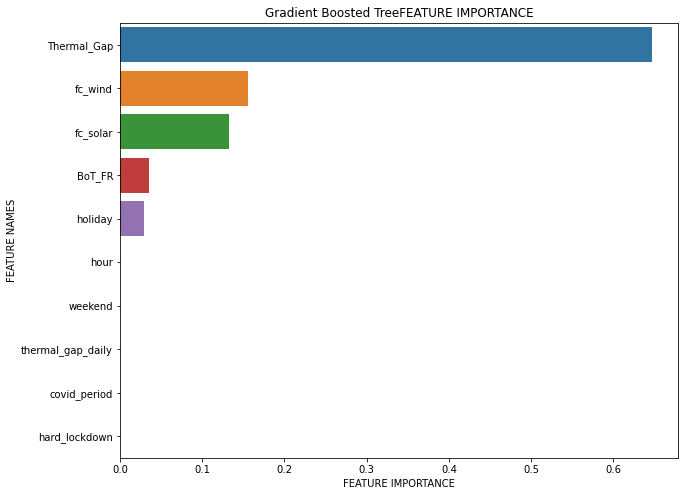

In [181]:
#sort the values based on their importance

feature_importances = pd.DataFrame(boosted_tree_reg.feature_importances_, index = Btss_X_train.columns,columns=['importance']).sort_values('importance', ascending=False)
feature_importances

plt.figure(figsize=(10,8))
#Plot Searborn bar chart
sns.barplot(x=list(feature_importances['importance']), y=Btss_X_train.columns)
#Add chart labels
plt.title('Gradient Boosted Tree' + 'FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES') 

In [182]:
# plot decision tree
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt

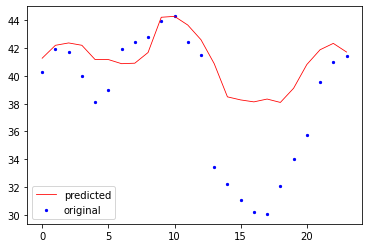

In [183]:
#Finally, we'll visualize the original and predicted values in a plot.
x_ax = range(len(Btss_y_test))
plt.scatter(x_ax, Btss_y_test, s=5, color="blue", label="original")
plt.plot(x_ax, boosted_tree_price_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

In [184]:
results_df.loc[len(results_df)] = [' Gradient Boosted Trees (BTSS)', mean_squared_error(Btss_y_test,boosted_tree_reg.predict(Btss_X_test) , squared=False)]
results_df

Algorithm       RMSE
0                      LR Baseline  17.767744
1                LR Baseline (TSS)  10.468930
2               LR Baseline (BTSS)   4.398897
3      Ridge LR Standardized (TSS)   9.294806
4                   Ridge LR (TSS)  10.466368
5     Ridge LR Standardized (BTSS)   4.484383
6                  Ridge LR (BTSS)   4.398964
7      Lasso LR Standardized (TSS)   9.696076
8                   Lasso LR (TSS)  10.550067
9     Lasso LR Standardized (BTSS)   5.259953
10                 Lasso LR (BTSS)   4.415596
11              Random Forest(TSS)   8.211579
12             Random Forest(BTSS)   4.295087
13                SVR Standardized   8.591501
14                      SVR (BTSS)  38.654286
15             Decision Tree (TSS)   9.080890
16            Decision Tree (BTSS)   4.743625
17     Gradient Boosted Tree (TSS)  10.203069
18   Gradient Boosted Trees (BTSS)   4.089170

#### 13. XGBoost

##### 13.1 XGBoost (TSS)

In [185]:
import xgboost as xgb

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(Tss_X_train, Tss_y_train, eval_set = [(Tss_X_test,Tss_y_test)], early_stopping_rounds = 2)

xgb_price_pred = xgb_reg.predict(Tss_X_test)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % xgb_reg.score(Tss_X_train, Tss_y_train))
print('Test R-Squared: %.2f' % r2_score(Tss_y_test,xgb_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Tss_y_test, xgb_price_pred, squared=False))

[0]	validation_0-rmse:32.39589
[1]	validation_0-rmse:25.04206
[2]	validation_0-rmse:20.06856
[3]	validation_0-rmse:16.33344
[4]	validation_0-rmse:14.05281
[5]	validation_0-rmse:12.25334
[6]	validation_0-rmse:10.87538
[7]	validation_0-rmse:10.06489
[8]	validation_0-rmse:9.61827
[9]	validation_0-rmse:9.24629
[10]	validation_0-rmse:9.08200
[11]	validation_0-rmse:8.98298
[12]	validation_0-rmse:8.80229
[13]	validation_0-rmse:8.74208
[14]	validation_0-rmse:8.76290
Train R-Squared: 0.75
Test R-Squared: -0.49
Test RMSE: 8.74


In [186]:
results_df.loc[len(results_df)] = [' XGBoost (TSS)', mean_squared_error(Tss_y_test,xgb_reg.predict(Tss_X_test) , squared=False)]
results_df

Algorithm       RMSE
0                      LR Baseline  17.767744
1                LR Baseline (TSS)  10.468930
2               LR Baseline (BTSS)   4.398897
3      Ridge LR Standardized (TSS)   9.294806
4                   Ridge LR (TSS)  10.466368
5     Ridge LR Standardized (BTSS)   4.484383
6                  Ridge LR (BTSS)   4.398964
7      Lasso LR Standardized (TSS)   9.696076
8                   Lasso LR (TSS)  10.550067
9     Lasso LR Standardized (BTSS)   5.259953
10                 Lasso LR (BTSS)   4.415596
11              Random Forest(TSS)   8.211579
12             Random Forest(BTSS)   4.295087
13                SVR Standardized   8.591501
14                      SVR (BTSS)  38.654286
15             Decision Tree (TSS)   9.080890
16            Decision Tree (BTSS)   4.743625
17     Gradient Boosted Tree (TSS)  10.203069
18   Gradient Boosted Trees (BTSS)   4.089170
19                   XGBoost (TSS)   8.742080

In [187]:
xgb_df = pd.DataFrame({'Actual': Tss_y_test, 'Predicted': xgb_price_pred})
xgb_df.head(5)

Actual  Predicted
32112   30.82  29.293978
32113   28.89  28.516697
32114   28.43  28.747250
32115   29.41  28.425951
32116   34.39  28.425951

#### 13.2 XGBoost (BTSS)

In [188]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(Btss_X_train, Btss_y_train, eval_set = [(Btss_X_test,Btss_y_test)], early_stopping_rounds = 2)

xgb_price_pred = xgb_reg.predict(Btss_X_test)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % xgb_reg.score(Btss_X_train, Btss_y_train))
print('Test R-Squared: %.2f' % r2_score(Btss_y_test,xgb_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Btss_y_test, xgb_price_pred, squared=False))

[0]	validation_0-rmse:26.74565
[1]	validation_0-rmse:18.77427
[2]	validation_0-rmse:12.99484
[3]	validation_0-rmse:9.16575
[4]	validation_0-rmse:6.62573
[5]	validation_0-rmse:5.04318
[6]	validation_0-rmse:4.22457
[7]	validation_0-rmse:3.72308
[8]	validation_0-rmse:3.63408
[9]	validation_0-rmse:3.67644
Train R-Squared: 0.58
Test R-Squared: 0.37
Test RMSE: 3.63


In [189]:
xgb_df = pd.DataFrame({'Actual': Btss_y_test, 'Predicted': xgb_price_pred})
xgb_df.head(5)

Actual  Predicted
31690   40.29  39.727024
31691   41.93  39.727024
31692   41.74  39.727024
31693   39.99  39.727024
31694   38.09  39.727024

In [190]:
scores = cross_val_score(xgb_reg, Btss_X_train, Btss_y_train, cv=47, scoring='neg_root_mean_squared_error')
xgb_rmse_scores = (-scores)
display_scores(xgb_rmse_scores)

Scores: [-0.46249313 -0.63126038 -1.2125766  -0.23918533 -0.56610657 -0.89927551
 -1.31368729 -0.67440857 -0.86233292 -0.80303665 -0.53439301 -2.25792953
 -1.00716187 -3.48116852 -3.22890823 -1.74317093 -0.42731972 -1.8951416
 -4.53085487 -0.81573868 -0.32423172 -0.61013168 -0.63812775 -0.05981262
 -0.41375656 -0.50074554 -0.78817795 -0.06764603 -0.46214081 -0.5284407
 -0.79828644 -0.98352295 -0.50990753 -1.04829819 -0.15931747 -0.93828979
 -1.09538956 -0.74007843 -1.10343933 -1.54846786 -0.67726486 -5.27899582
 -1.17625153 -1.00874939 -0.01632996 -0.00603317 -0.42066788]
Mean -1.0529500303877157
Standard Deviation: 1.0743075438043515


In [191]:
results_df.loc[len(results_df)] = [' XGBoost (BTSS)', mean_squared_error(Btss_y_test,xgb_reg.predict(Btss_X_test) , squared=False)]
results_df

Algorithm       RMSE
0                      LR Baseline  17.767744
1                LR Baseline (TSS)  10.468930
2               LR Baseline (BTSS)   4.398897
3      Ridge LR Standardized (TSS)   9.294806
4                   Ridge LR (TSS)  10.466368
5     Ridge LR Standardized (BTSS)   4.484383
6                  Ridge LR (BTSS)   4.398964
7      Lasso LR Standardized (TSS)   9.696076
8                   Lasso LR (TSS)  10.550067
9     Lasso LR Standardized (BTSS)   5.259953
10                 Lasso LR (BTSS)   4.415596
11              Random Forest(TSS)   8.211579
12             Random Forest(BTSS)   4.295087
13                SVR Standardized   8.591501
14                      SVR (BTSS)  38.654286
15             Decision Tree (TSS)   9.080890
16            Decision Tree (BTSS)   4.743625
17     Gradient Boosted Tree (TSS)  10.203069
18   Gradient Boosted Trees (BTSS)   4.089170
19                   XGBoost (TSS)   8.742080
20                  XGBoost (BTSS)   3.634085

In [192]:
# Grid of hyperparameters to search over
param_grid = [{'learning_rate': [0.01,0.1,0.5,0.9],'n_estimators' : [200],'subsample' : [0.3,0.5,0.9]}]
             
grid_search = GridSearchCV(xgb_reg, param_grid , cv = 10 , scoring = 'neg_root_mean_squared_error', return_train_score = True)

grid_search.fit(Btss_X_train, Btss_y_train)

grid_search.best_params_

{'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.3}

In [193]:
grid_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.3,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [194]:
xgb_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.3,
             tree_method='exact', validate_parameters=1, verbosity=None)

xgb_reg.fit(Btss_X_train, Btss_y_train)

xgb_price_pred = xgb_reg.predict(Btss_X_test)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % xgb_reg.score(Btss_X_train, Btss_y_train))
print('Test R-Squared: %.2f' % r2_score(Btss_y_test,xgb_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Btss_y_test, xgb_price_pred, squared=False))

Train R-Squared: 1.00
Test R-Squared: 0.08
Test RMSE: 4.42


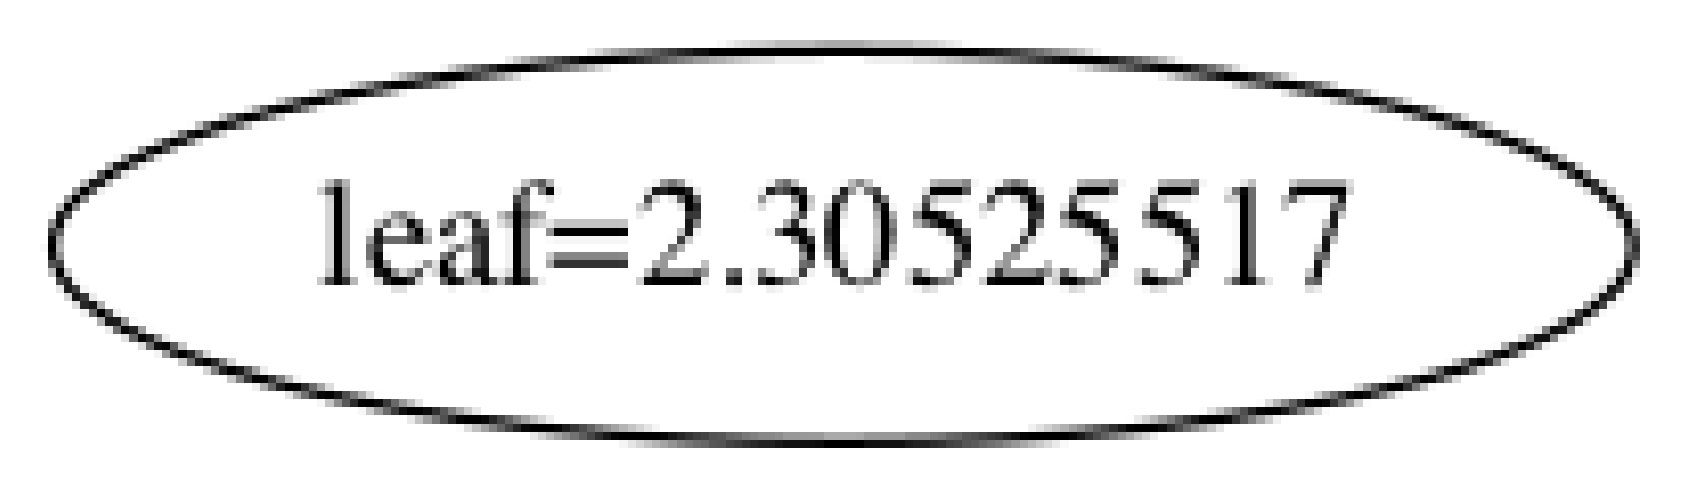

In [195]:
#Plotting number 
from xgboost import XGBClassifier
from xgboost import plot_tree
plot_tree(xgb_reg, num_trees=5) #gathering just a sample of the final tree
fig = plt.gcf()
fig.set_size_inches(30, 15)

In [196]:
#results_df.loc[len(results_df)] = [' XGBoost (BTSS)', mean_squared_error(Btss_y_test,xgb_reg.predict(Btss_X_test) , squared=False)]
#results_df

### Top 3 - Candidate Models:

Ridge LR: -1.231071 (0.894640)
Random Forest: -0.991281 (0.806767)
Gradient Boost: -0.970753 (1.015548)


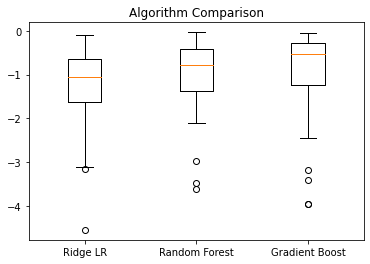

In [197]:
# Comparison of the Top 3 Models:
models = []
models.append(('Ridge LR', Ridge(alpha = 1, solver = "cholesky")))
models.append(('Random Forest', RandomForestRegressor(max_features=6, n_estimators=365)))
models.append(('Gradient Boost', GradientBoostingRegressor(max_depth=12, max_features=6, n_estimators=1000)))

# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 btss = BlockingTimeSeriesSplit(n_splits=446)
    
 cv_results = cross_val_score(model, Btss_X_train, Btss_y_train, cv=47, scoring='neg_root_mean_squared_error')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [198]:
#TOO HEAVY TO COMPUTE (BUT WE MANAGED TO OBTAIN RESULTS FOR REGRESSION & RANDOM FOREST , BOTH WORSE)
# Comparison of the Top 3 Models using TSS has a cross-validation technique (whole dataset):
#models = []
#models.append(('Ridge LR', Ridge(alpha = 1, solver = "cholesky")))
#models.append(('Random Forest', RandomForestRegressor(max_features=6, n_estimators=365)))
#models.append(('Gradient Boost', GradientBoostingRegressor(max_depth=12, max_features=6, n_estimators=1000)))

# Evaluate each model in turn
#results = []
#names = []
#for name, model in models:
    # TimeSeries Cross validation
 #tss = TimeSeriesSplit(n_splits=1338)
    
 #cv_results = cross_val_score(model, X_train, y_train, cv=tss, scoring='neg_root_mean_squared_error')
 #results.append(cv_results)
 #names.append(name)
 #print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
#plt.boxplot(results, labels=names)
#plt.title('Algorithm Comparison')
#plt.show()

Ridge LR: -5.070571 (3.563486)
Random Forest: -3.969475 (2.617940)
Gradient Boost: -4.044481 (2.592353)


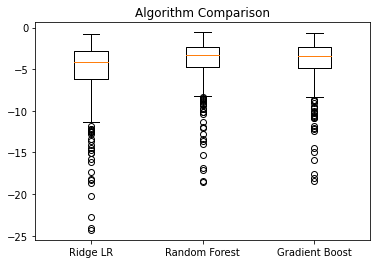

In [199]:
# Comparison of the Top 3 Models using BTSS has a cross validation technique (whole dataset):
models = []
models.append(('Ridge LR', Ridge(alpha = 1, solver = "cholesky")))
models.append(('Random Forest', RandomForestRegressor(max_features=6, n_estimators=365)))
models.append(('Gradient Boost', GradientBoostingRegressor(max_depth=12, max_features=6, n_estimators=1000)))

# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 btss = BlockingTimeSeriesSplit(n_splits=446)
    
 cv_results = cross_val_score(model, X_train, y_train, cv=btss, scoring='neg_root_mean_squared_error')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

## Obtaining Predictions

#### Loading & Transforming Scoring Dataset

In [200]:
scoring_df = pd.read_csv("scoring.csv")
scoring_df.head(5)

fc_demand  fc_nuclear  import_FR  export_FR  fc_wind  fc_solar_pv  \
0    24744.0      7117.2     2300.0     1750.0   2751.0          0.0   
1    23426.0      7117.2     2300.0     2100.0   2452.0          0.0   
2    22597.0      7117.2     2300.0     2100.0   2060.0          0.0   
3    22285.0      7117.2     2300.0     2100.0   1736.0          0.0   
4    22192.0      7117.2     2300.0     2100.0   1322.0          0.0   

   fc_solar_th        date  hour  
0        627.1  2020-09-01     0  
1        606.6  2020-09-01     1  
2        528.3  2020-09-01     2  
3        598.5  2020-09-01     3  
4        474.9  2020-09-01     4

In [201]:
scoring_df.describe(include = 'all')

fc_demand   fc_nuclear    import_FR    export_FR       fc_wind  \
count    3673.000000  3673.000000  3673.000000  3673.000000   3673.000000   
unique           NaN          NaN          NaN          NaN           NaN   
top              NaN          NaN          NaN          NaN           NaN   
freq             NaN          NaN          NaN          NaN           NaN   
mean    28049.892186  6762.296624  2454.465015  2116.430711   7595.305472   
std      4876.154745   467.608441   205.749847   268.054958   4171.177434   
min      8644.000000  5691.600000  2100.000000  1200.000000    488.000000   
25%     23961.000000  6125.500000  2400.000000  2100.000000   4214.000000   
50%     28347.000000  7117.200000  2400.000000  2200.000000   6993.000000   
75%     31481.000000  7117.200000  2500.000000  2200.000000  10435.000000   
max     41615.000000  7117.200000  3000.000000  2800.000000  19287.000000   

        fc_solar_pv  fc_solar_th        date         hour  
count   3673.000000  3673.000000        3673  3673.000000  
unique          NaN          NaN         153          NaN  
top             NaN          NaN  2020-10-25          NaN  
freq            NaN          NaN          25          NaN  
mean    1406.153526   306.545576         NaN    11.497414  
std     2050.604746   507.322833         NaN     6.923961  
min        0.000000     0.000000         NaN     0.000000  
25%        0.000000    10.300000         NaN     5.000000  
50%        0.000000    35.800000         NaN    11.000000  
75%     2742.300000   375.000000         NaN    17.000000  
max     6945.200000  2150.300000         NaN    23.000000

In [202]:
#Combining solar energies:
scoring_df['fc_solar'] = scoring_df['fc_solar_th'] + scoring_df['fc_solar_pv'] 

#Creating the aforementioned Thermal Gap:
scoring_df['Thermal_Gap'] = scoring_df['fc_demand'] - scoring_df['fc_nuclear'] - scoring_df['fc_wind'] - scoring_df['fc_solar']

#Creating Energy Trade Balance SPAIN/FR
scoring_df['BoT_FR'] = scoring_df['export_FR'] - scoring_df['import_FR']
scoring_df = scoring_df.drop(columns = ['import_FR','export_FR','fc_solar_pv','fc_solar_th'], axis = 1)

#Converting dataframe series "date" into datetime to use dt. functionalities:
scoring_df['date'] = pd.to_datetime(scoring_df['date'])

# Adding additional columns with year & day of the year:
scoring_df['Year'] = scoring_df['date'].dt.year
scoring_df['Day_of_Year'] = scoring_df['date'].dt.dayofyear

#Adding column for feature weekend
scoring_df['weekend'] = scoring_df['date'].dt.dayofweek
scoring_df['weekend'].replace({1:0})
scoring_df['weekend'] = scoring_df['weekend'].apply(weekend)

festivos = ['2020-10-12','2020-12-08','2020-12-25','2021-01-01','2021-01-06']
festivosdate = pd.to_datetime(festivos)
scoring_df['holiday'] = scoring_df['date'].isin(festivosdate)
scoring_df['holiday'] = scoring_df['holiday'].apply(holiday)
scoring_df['covid_period'] = pd.Series([1 for x in range(len(scoring_df.index))]) # all forecasting periods are within covid period
scoring_df['hard_lockdown'] = pd.Series([0 for x in range(len(scoring_df.index))]) #no hard lockdowns 

Thermal_Gap_df = pd.concat([pm_df.iloc[-24:]['Thermal_Gap'],scoring_df['Thermal_Gap']])
hourly_lag = Thermal_Gap_df.diff()
daily_lag = Thermal_Gap_df.diff(periods = 24)
scoring_df['thermal_gap_lag_hourly']=hourly_lag.iloc[24:]
scoring_df['thermal_gap_daily']=daily_lag.iloc[24:]
scoring_df = scoring_df.drop(columns = ['date'], axis = 1)
scoring_df.head(5)

fc_demand  fc_nuclear  fc_wind  hour  fc_solar  Thermal_Gap  BoT_FR  Year  \
0    24744.0      7117.2   2751.0     0     627.1      14248.7  -550.0  2020   
1    23426.0      7117.2   2452.0     1     606.6      13250.2  -200.0  2020   
2    22597.0      7117.2   2060.0     2     528.3      12891.5  -200.0  2020   
3    22285.0      7117.2   1736.0     3     598.5      12833.3  -200.0  2020   
4    22192.0      7117.2   1322.0     4     474.9      13277.9  -200.0  2020   

   Day_of_Year  weekend  holiday  covid_period  hard_lockdown  \
0          245        0        0             1              0   
1          245        0        0             1              0   
2          245        0        0             1              0   
3          245        0        0             1              0   
4          245        0        0             1              0   

   thermal_gap_lag_hourly  thermal_gap_daily  
0                 -1942.3             6115.6  
1                  -998.5             6335.1  
2                  -358.7             6352.5  
3                   -58.2             6422.9  
4                   444.6             6087.7

In [205]:
from pandas_profiling import ProfileReport
scoring_report = ProfileReport(scoring_df, minimal=False)
scoring_report

#### Making Predictions

In [206]:
# In case Predictions need to be re-scaled:
scaler = StandardScaler().fit(scoring_df)
standard_scoring_df = scaler.transform(scoring_df)
standard_scoring_df = pd.DataFrame(data = standard_scoring_df, index = None , columns = scoring_df.columns)
standard_scoring_df.head(12)

fc_demand  fc_nuclear   fc_wind      hour  fc_solar  Thermal_Gap  \
0   -0.678063    0.759079 -1.161534 -1.660752 -0.439704     0.379601   
1   -0.948395    0.759079 -1.233226 -1.516306 -0.448008     0.212561   
2   -1.118429    0.759079 -1.327217 -1.371860 -0.479722     0.152554   
3   -1.182423    0.759079 -1.404904 -1.227415 -0.451288     0.142818   
4   -1.201498    0.759079 -1.504170 -1.082969 -0.501351     0.217195   
5   -1.135658    0.759079 -1.549967 -0.938523 -0.597101     0.342395   
6   -0.733237    0.759079 -1.541095 -0.794078 -0.651497     0.686897   
7   -0.255952    0.759079 -1.540615 -0.649632 -0.675677     1.085836   
8    0.093141    0.759079 -1.563873 -0.505186 -0.451491     1.294196   
9    0.360601    0.759079 -1.601278 -0.360741  0.105552     1.308366   
10   0.579656    0.759079 -1.625255 -0.216295  0.801360     1.216372   
11   0.673595    0.759079 -1.624536 -0.071849  1.298336     1.087224   

      BoT_FR      Year  Day_of_Year   weekend   holiday  covid_period  \
0  -0.687667 -0.503996    -0.015402 -0.635651 -0.183778           0.0   
1   0.447816 -0.503996    -0.015402 -0.635651 -0.183778           0.0   
2   0.447816 -0.503996    -0.015402 -0.635651 -0.183778           0.0   
3   0.447816 -0.503996    -0.015402 -0.635651 -0.183778           0.0   
4   0.447816 -0.503996    -0.015402 -0.635651 -0.183778           0.0   
5   0.447816 -0.503996    -0.015402 -0.635651 -0.183778           0.0   
6   0.447816 -0.503996    -0.015402 -0.635651 -0.183778           0.0   
7  -0.687667 -0.503996    -0.015402 -0.635651 -0.183778           0.0   
8  -0.687667 -0.503996    -0.015402 -0.635651 -0.183778           0.0   
9  -0.687667 -0.503996    -0.015402 -0.635651 -0.183778           0.0   
10 -0.687667 -0.503996    -0.015402 -0.635651 -0.183778           0.0   
11 -0.687667 -0.503996    -0.015402 -0.635651 -0.183778           0.0   

    hard_lockdown  thermal_gap_lag_hourly  thermal_gap_daily  
0             0.0               -1.144410           1.295233  
1             0.0               -0.587317           1.341298  
2             0.0               -0.209664           1.344950  
3             0.0               -0.032289           1.359724  
4             0.0                0.264497           1.289378  
5             0.0                0.443820           1.270617  
6             0.0                1.217601           1.220396  
7             0.0                1.409674           1.248917  
8             0.0                0.737242           1.186378  
9             0.0                0.052060           1.267657  
10            0.0               -0.322523           1.531014  
11            0.0               -0.453621           1.232038

In [207]:
#Matching variables used for training as well as variable order
scoring_df = scoring_df.loc[:,['Thermal_Gap', 'fc_wind' , 'fc_solar', 'BoT_FR' , 'holiday' , 'hour', 'weekend' , 'thermal_gap_daily', 'covid_period', 'hard_lockdown']]

In [208]:
scoring_df.head()

Thermal_Gap  fc_wind  fc_solar  BoT_FR  holiday  hour  weekend  \
0      14248.7   2751.0     627.1  -550.0        0     0        0   
1      13250.2   2452.0     606.6  -200.0        0     1        0   
2      12891.5   2060.0     528.3  -200.0        0     2        0   
3      12833.3   1736.0     598.5  -200.0        0     3        0   
4      13277.9   1322.0     474.9  -200.0        0     4        0   

   thermal_gap_daily  covid_period  hard_lockdown  
0             6115.6             1              0  
1             6335.1             1              0  
2             6352.5             1              0  
3             6422.9             1              0  
4             6087.7             1              0

In [209]:
price_pred = forest_reg.predict(scoring_df)

In [210]:
len(price_pred)

3673

In [211]:
#index = scoring_df['date']
output = pd.DataFrame({'Price': price_pred})
output.to_csv('ML_group_assignment_predictions_group_H.csv', index = False)
output.head()

Price
0  39.741014
1  38.580630
2  38.277068
3  37.804110
4  38.147562

In [212]:
#De-standardizing the predicted output(if needed)
#mean = y.iloc[test_index].mean()
#std = y.iloc[test_index].std()
#svr_df_destandardized = output.apply(lambda row:((row*std)+mean),axis =1)
#svr_df_destandardized.head(5)

## Appendix

#### Price Lag Analysis (Example Only - Analysis can be replicated with the Notebook)

In [213]:
X = pm_df.loc[:,['Thermal_Gap', 'fc_wind' , 'fc_solar', 'BoT_FR' , 'holiday' , 'hour', 'weekend' , 'price_lag_daily', 'covid_period', 'hard_lockdown']]
y = pm_df['price']

In [214]:
#Using BTSS
btss = BlockingTimeSeriesSplit(n_splits = 446)
for train_index, test_index in btss.split(X):
    Btss_X_train, Btss_X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    Btss_y_train, Btss_y_test = y.iloc[train_index], y.iloc[test_index]

In [215]:
forest_reg = RandomForestRegressor()
forest_reg.fit(Btss_X_train, Btss_y_train)

forest_price_pred = forest_reg.predict(Btss_X_test)

# The coefficient of determination: R-squared
print('Train R-Squared: %.2f' % forest_reg.score(Btss_X_train, Btss_y_train))
print('Test R-Squared: %.2f' % r2_score(Btss_y_test,forest_price_pred))

# RMSE:
print('Test RMSE: %.2f' % mean_squared_error(Btss_y_test, forest_price_pred, squared=False))

Train R-Squared: 0.97
Test R-Squared: 0.17
Test RMSE: 4.19


### Emphasizing Covid Period (Training and Test Sets during Covid Times exclusively)

In [216]:
covid_df = pm_df[pm_df['covid_period'] == 1]

In [217]:
len(covid_df)

4103

In [218]:
Covid_X = covid_df.loc[:,['Thermal_Gap', 'fc_wind' , 'fc_solar', 'BoT_FR' , 'holiday' , 'hour', 'weekend' , 'thermal_gap_daily', 'hard_lockdown']]
Covid_y = covid_df['price']

Covid_X_train, Covid_X_test, Covid_y_train, Covid_y_test = train_test_split(Covid_X, Covid_y, test_size=0.2, random_state=42 , shuffle=False) #shuffle = False means we remove data in orderly fashion

In [219]:
Covid_X_test

Thermal_Gap  fc_wind  fc_solar  BoT_FR  holiday  hour  weekend  \
31314      15450.6   7779.0    4695.2    50.0        0  19.0        0   
31315      15814.3   8681.0    2429.5    50.0        0  20.0        0   
31316      16769.3   8993.0     930.5    50.0        0  21.0        0   
31317      16010.7   9190.0     604.1    50.0        0  22.0        0   
31318      14105.6   8910.0     576.2    50.0        0  23.0        0   
...            ...      ...       ...     ...      ...   ...      ...   
32130      15218.4   2846.0    3650.4  -450.0        0  19.0        0   
32131      18131.7   2861.0    1343.1  -450.0        0  20.0        0   
32132      20026.3   2859.0     682.5  -450.0        0  21.0        0   
32133      18212.5   2771.0     598.3  -450.0        0  22.0        0   
32134      16191.0   2746.0     617.8  -450.0        0  23.0        0   

       thermal_gap_daily  hard_lockdown  
31314            -2995.5              0  
31315            -4293.5              0  
31316            -4038.7              0  
31317            -3539.3              0  
31318            -2818.3              0  
...                  ...            ...  
32130             9953.1              0  
32131            10280.9              0  
32132             9197.1              0  
32133             7631.9              0  
32134             6751.7              0  

[821 rows x 9 columns]

In [220]:
boosted_tree_reg = GradientBoostingRegressor()
boosted_tree_reg.fit(Covid_X_train, Covid_y_train)

boosted_tree_price_pred = boosted_tree_reg.predict(Covid_X_test)

boosted_tree_mse = mean_squared_error(Covid_y_test, boosted_tree_price_pred)

boosted_tree_rmse = np.sqrt(boosted_tree_mse)

# The mean squared error
print(' Root Mean Squared Error: %.2f'
      % boosted_tree_rmse)

 Root Mean Squared Error: 4.63


In [221]:
required_splits = (len(covid_df.index)/24)
print(required_splits)

170.95833333333334


In [222]:
ctss = TimeSeriesSplit(n_splits = 171)
print(ctss)

TimeSeriesSplit(max_train_size=None, n_splits=171)


In [223]:
for train_index, test_index in ctss.split(Covid_X):
    ctss_X_train, ctss_X_test = Covid_X.iloc[train_index, :], Covid_X.iloc[test_index,:]
    ctss_y_train, ctss_y_test = Covid_y.iloc[train_index], Covid_y.iloc[test_index]

In [224]:
boosted_tree_reg.fit(ctss_X_train, ctss_y_train)

boosted_tree_price_pred = boosted_tree_reg.predict(ctss_X_test)

boosted_tree_mse = mean_squared_error(ctss_y_test, boosted_tree_price_pred)

boosted_tree_rmse = np.sqrt(boosted_tree_mse)

# The mean squared error
print(' Root Mean Squared Error: %.2f'
      % boosted_tree_rmse)

 Root Mean Squared Error: 7.81


In [225]:
required_splits = (len(covid_df.index)/(24*3))
print(required_splits)

56.986111111111114


In [226]:
bctss = BlockingTimeSeriesSplit(n_splits = 57 )
print(bctss)

In [227]:
for train_index, test_index in bctss.split(Covid_X):
    bctss_X_train, bctss_X_test = Covid_X.iloc[train_index, :], Covid_X.iloc[test_index,:]
    bctss_y_train, bctss_y_test = Covid_y.iloc[train_index], Covid_y.iloc[test_index]

In [228]:
boosted_tree_reg.fit(bctss_X_train, bctss_y_train)

boosted_tree_price_pred = boosted_tree_reg.predict(bctss_X_test)

boosted_tree_mse = mean_squared_error(bctss_y_test, boosted_tree_price_pred)

boosted_tree_rmse = np.sqrt(boosted_tree_mse)

# The mean squared error
print(' Root Mean Squared Error: %.2f'
      % boosted_tree_rmse)

 Root Mean Squared Error: 6.65


### Emphasizing Covid Period (Training Set September 2019 - September 2020)

In [229]:
year_train_df = pm_df[23327:] ### Beginning the dataset the 01/01/2019
year_train_df.head()

fc_demand  fc_nuclear  fc_wind  price  hour  fc_solar  Thermal_Gap  \
23375    25462.0      7117.2   9759.0  33.00   0.0     462.8       8123.0   
23376    24014.0      7117.2   9371.0  30.50   1.0     400.9       7124.9   
23377    23048.0      7117.2   9054.0  25.96   2.0     228.3       6648.5   
23378    22641.0      7117.2   9177.0  25.00   3.0     174.1       6172.7   
23379    22487.0      7117.2   9360.0  25.63   4.0      39.1       5970.7   

       BoT_FR  Year  Day_of_Year  weekend  holiday  covid_period  \
23375  -750.0  2019          245        0        0             0   
23376     0.0  2019          245        0        0             0   
23377     0.0  2019          245        0        0             0   
23378     0.0  2019          245        0        0             0   
23379     0.0  2019          245        0        0             0   

       hard_lockdown  price_lag_hourly  price_lag_daily  \
23375              0             -4.50           -13.53   
23376              0             -2.50           -11.51   
23377              0             -4.54           -14.04   
23378              0             -0.96           -16.42   
23379              0              0.63           -15.45   

       thermal_gap_lag_hourly  thermal_gap_daily  
23375                 -1233.5            -6359.0  
23376                  -998.1            -5992.5  
23377                  -476.4            -6027.8  
23378                  -475.8            -5944.7  
23379                  -202.0            -5581.2

In [230]:
Year_X = year_train_df.loc[:,['Thermal_Gap', 'fc_wind' , 'fc_solar', 'BoT_FR' , 'holiday' , 'hour', 'weekend' , 'thermal_gap_daily', 'covid_period', 'hard_lockdown']]
Year_y = year_train_df['price']

Year_X_train, Year_X_test, Year_y_train, Year_y_test = train_test_split(Year_X, Year_y, test_size=0.2, random_state=42 , shuffle=False) #shuffle = False means we remove data in orderly fashion

In [231]:
len(year_train_df)

8760

In [232]:
Year_X_test

Thermal_Gap  fc_wind  fc_solar  BoT_FR  holiday  hour  weekend  \
30383      14502.9   3833.0     609.6  -750.0        0   0.0        1   
30384      13501.5   3540.0     596.0  -750.0        0   1.0        1   
30385      13116.5   3071.0     567.0  -250.0        0   2.0        1   
30386      12975.2   2615.0     552.3  -250.0        0   3.0        1   
30387      13132.6   2132.0     548.9  -250.0        0   4.0        1   
...            ...      ...       ...     ...      ...   ...      ...   
32130      15218.4   2846.0    3650.4  -450.0        0  19.0        0   
32131      18131.7   2861.0    1343.1  -450.0        0  20.0        0   
32132      20026.3   2859.0     682.5  -450.0        0  21.0        0   
32133      18212.5   2771.0     598.3  -450.0        0  22.0        0   
32134      16191.0   2746.0     617.8  -450.0        0  23.0        0   

       thermal_gap_daily  covid_period  hard_lockdown  
30383             -416.8             1              1  
30384              -73.1             1              1  
30385              157.6             1              1  
30386               79.2             1              1  
30387              111.4             1              1  
...                  ...           ...            ...  
32130             9953.1             1              0  
32131            10280.9             1              0  
32132             9197.1             1              0  
32133             7631.9             1              0  
32134             6751.7             1              0  

[1752 rows x 10 columns]

In [233]:
required_splits = (len(year_train_df.index)/(24*3))
print(required_splits)

121.66666666666667


In [234]:
bytss = BlockingTimeSeriesSplit(n_splits = 122)
print(bytss)

In [235]:
for train_index, test_index in bytss.split(year_train_df):
    bytss_X_train, bytss_X_test = Year_X.iloc[train_index, :], Year_X.iloc[test_index,:]
    bytss_y_train, bytss_y_test = Year_y.iloc[train_index], Year_y.iloc[test_index]
bytss_y_test.head()

32013    48.38
32014    44.86
32015    46.91
32016    42.91
32017    40.02
Name: price, dtype: float64

In [236]:
boosted_tree_reg.fit(bytss_X_train, bytss_y_train)

boosted_tree_price_pred = boosted_tree_reg.predict(bytss_X_test)

boosted_tree_mse = mean_squared_error(bytss_y_test, boosted_tree_price_pred)

boosted_tree_rmse = np.sqrt(boosted_tree_mse)

print('Train R-Squared: %.2f' % boosted_tree_reg.score(bytss_X_train,bytss_y_train))
print('Test R-Squared: %.2f' % r2_score(bytss_y_test,boosted_tree_price_pred))

# The mean squared error
print('Root Mean Squared Error: %.2f'
      % boosted_tree_rmse)

Train R-Squared: 1.00
Test R-Squared: -4.25
Root Mean Squared Error: 8.74


##### Imputation w/ Linear Regression

In [237]:
# BoT_FR is the target variable in order to fill in the 'bfill' values 
X_imp = pm_df.loc[:, pm_df.columns != 'BoT_FR']
y_imp = pm_df['BoT_FR']

In [238]:
btss_imp = BlockingTimeSeriesSplit(n_splits = 77)
print(btss_imp)

In [239]:
for train_index, test_index in btss_imp.split(X_imp):
    Btss_X_imp_train, Btss_X_imp_test = X_imp.iloc[train_index, :], X_imp.iloc[test_index,:]
    Btss_y_imp_train, Btss_y_imp_test = y_imp.iloc[train_index], y_imp.iloc[test_index]
Btss_X_imp_test.head(5)

fc_demand  fc_nuclear  fc_wind  price  hour  fc_solar  Thermal_Gap  \
31941    27840.0      7117.2   6714.0  38.07  22.0     620.5      13388.3   
31942    26342.0      7117.2   6953.0  31.99  23.0     618.6      11653.2   
31943    24447.0      7117.2   6849.0  32.26   0.0     626.5       9854.3   
31944    22954.0      7117.2   6712.0  27.95   1.0     615.7       8509.1   
31945    21964.0      7117.2   6660.0  27.14   2.0     611.9       7574.9   

       Year  Day_of_Year  weekend  holiday  covid_period  hard_lockdown  \
31941  2020          236        1        0             1              0   
31942  2020          236        1        0             1              0   
31943  2020          237        0        0             1              0   
31944  2020          237        0        0             1              0   
31945  2020          237        0        0             1              0   

       price_lag_hourly  price_lag_daily  thermal_gap_lag_hourly  \
31941             -0.80            -1.72                  -580.3   
31942             -6.08            -5.88                 -1735.1   
31943              0.27            -5.81                 -1798.9   
31944             -4.31            -7.58                 -1345.2   
31945             -0.81            -4.74                  -934.2   

       thermal_gap_daily  
31941            -2970.6  
31942            -2634.9  
31943            -2409.9  
31944            -2413.4  
31945            -2319.2

In [240]:
imp_lr = LinearRegression()

# Train the model using the training sets
imp_lr.fit(Btss_X_imp_train, Btss_y_imp_train)

# Make predictions using the testing set
Btss_BoT_pred = imp_lr.predict(Btss_X_imp_test)
# The coefficients
print('Coefficients: \n', imp_lr.coef_)

#Evaluation Metric
rmse = mean_squared_error(Btss_y_imp_test, Btss_BoT_pred, squared=False)
print('RMSE: %.2f'
      % rmse)

# The coefficient of determination:
print('Coefficient of determination: %.2f'
      % r2_score(Btss_y_imp_test, Btss_BoT_pred))

Coefficients: 
 [-4.24877770e-02 -1.69969493e-01  9.12309232e-02  8.55525977e+00
 -6.92270606e+00  3.20034472e-02  4.24734540e-03 -1.74082970e-13
 -2.66895629e+01 -2.41097437e+02  3.84586096e+02  5.68434189e-14
  7.10542736e-15 -8.36721440e+00 -1.50416682e+01  2.95086414e-02
  5.05099437e-02]
RMSE: 273.05
Coefficient of determination: -57.42


In [241]:
#Test Predictions were quite underperforming at first. We dropped any additional attempt of improving upon it since the new scoring dataset was provided.
values_to_be_imputed_df = pd.DataFrame({'Actual': Btss_y_imp_test, 'Predicted': Btss_BoT_pred})
values_to_be_imputed_df.head()

Actual   Predicted
31941     0.0 -573.456840
31942     0.0 -464.743180
31943  -300.0  -69.867189
31944  -300.0    9.370264
31945  -300.0  -26.370294